In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

import itertools
import datetime
import copy
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader as dl

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Sat Oct 10 00:07:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   30C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def param_search(neural_network_class, product, 
                 Xtrain, Ttrain, Xtest, Ttest,
                 epochs, batch_size, method, lr, verbose=False, **kwargs):
    # https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715
    
    train_history = []
    val_history = []

    best = float('inf')
    best_nnet = None
    best_info = None
    
    f = FloatProgress(min=0, max=len(product))
    display(f)
    for activation, layer in product:
        if 'Convolutional' in str(neural_network_class):
            nnet = neural_network_class(Xtrain.shape[1:], layer, kwargs['kernels_size_and_stride']*len(layer),
                                        Ttrain.shape[1], activation=activation)
        else:
            nnet = neural_network_class(Xtrain.shape[1], layer, Ttrain.shape[1],
                                        activation=activation)
        
        nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method,
                   learning_rate=lr, verbose=verbose, validation=[Xtest, Ttest])

        train_history.append(nnet.history['rmse'][-1])

        temp = nnet.history['val_rmse'][-1]
        val_history.append(temp)

        if temp < best:
            best = temp
            best_nnet = nnet
            best_info = {'epochs': epochs, 'batch_size': batch_size,
                         'method': method, 'lr': lr, 'activation': activation,
                         'layers': layer}
        f.value += 1
        
    print(best_info)
    return best_nnet, train_history, val_history


def plot_param_search(product, train_history, val_history, rotation=30):
    train_color = radiosonde_plotting.DEFAULT_OPTION_DICT[
        radiosonde_plotting.NWP_LINE_COLOUR_KEY]
    val_color = radiosonde_plotting.DEFAULT_OPTION_DICT[
        radiosonde_plotting.PREDICTED_LINE_COLOUR_KEY]
    
    plt.figure(figsize=(12, 5))
    plt.plot(train_history, 'o-', color=train_color)
    plt.plot(val_history, 'o-', color=val_color)

    best_index = np.argmin(val_history)
    best = val_history[best_index]

    plt.hlines(best, 0, len(product) - 1, linestyle='dashed', color='black')
    plt.plot(best_index, best, 'k*', markersize=12)
    plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
               rotation=rotation, horizontalalignment='right')

    plt.legend(('Train', 'Validation', f'Best: {best:.3f}'))
    plt.grid(True); plt.title('Network Variance')
    plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE (C)');

# Data Loader

In [4]:
raob, rap, goes, rtma, sonde_files = dl.load_preprocessed_samples(processed_vol, shuffle=True)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 1283 samples!


FloatProgress(value=0.0, max=1283.0)

time: 33.123, avg: 0.026 seconds
(1283, 256, 4) (1283, 256, 4) (1283, 3, 3, 8) (1283, 3, 3, 3)


(array([  2.,   0.,   0.,   1.,   2.,   4.,   2.,   5.,   7.,  17.,  22.,
         43.,  53.,  79.,  92., 112., 115., 101.,  95., 102., 137.,  99.,
         86.,  92.,  15.]),
 array([-48.40127571, -45.72076227, -43.04024882, -40.35973538,
        -37.67922194, -34.9987085 , -32.31819506, -29.63768162,
        -26.95716818, -24.27665474, -21.5961413 , -18.91562786,
        -16.23511442, -13.55460098, -10.87408754,  -8.1935741 ,
         -5.51306066,  -2.83254722,  -0.15203378,   2.52847966,
          5.2089931 ,   7.88950654,  10.57001998,  13.25053342,
         15.93104686,  18.61156031]),
 <BarContainer object of 25 artists>)

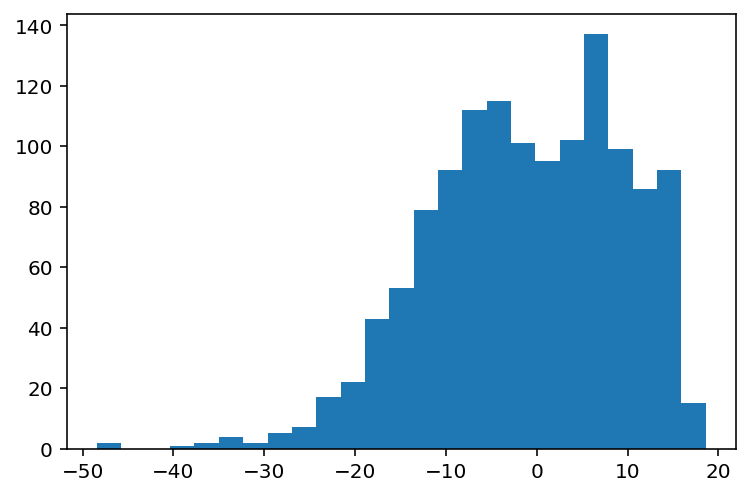

In [14]:
sfs = raob[:, 20, dl.DEWPOINT]
plt.hist(sfs, bins=25)

In [5]:
from glob import glob
from os.path import join

xar = xr.open_dataset(np.array(sorted(glob(join(processed_vol, '*'))))[0])

In [6]:
xar

<xarray.Dataset>
Dimensions:         (band: 8, goes_x: 3, goes_y: 3, nwp_dims: 50, profile_dims: 256, rtma_type: 3, rtma_x: 3, rtma_y: 3)
Coordinates:
  * goes_y          (goes_y) int64 0 1 2
  * goes_x          (goes_x) int64 0 1 2
  * band            (band) int64 8 9 10 11 13 14 15 16
  * rtma_y          (rtma_y) int64 0 1 2
  * rtma_x          (rtma_x) int64 0 1 2
  * rtma_type       (rtma_type) object 'LPI' 'LRI' 'LTI'
  * profile_dims    (profile_dims) int64 0 1 2 3 4 5 ... 250 251 252 253 254 255
  * nwp_dims        (nwp_dims) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    sonde_rel_time  datetime64[ns] ...
    sonde_file      object ...
    sonde_pres      (profile_dims) float64 ...
    sonde_tdry      (profile_dims) float64 ...
    sonde_dp        (profile_dims) float64 ...
    sonde_alt       (profile_dims) float64 ...
    nwp_file        object ...
    nwp_lon         object ...
    nwp_lat         object ...
    nwp_pres        (nwp_dims) float64 ...
    nwp_tdry        (nwp_dims) float64 ...
    nwp_spfm        (nwp_dims) float64 ...
    nwp_alt         (nwp_dims) float64 ...
    goes_files      (band) object ...
    goes_abi        (band, goes_y, goes_x) float32 ...
    goes_lon        (goes_y, goes_x) float64 ...
    goes_lat        (goes_y, goes_x) float64 ...
    rtma_files      (rtma_type) object ...
    rtma_values     (rtma_type, rtma_y, rtma_x) float32 ...
    rtma_lon        (rtma_y, rtma_x) float64 ...
    rtma_lat        (rtma_y, rtma_x) float64 ...

In [7]:
ml.rmse(rap[:,:,dl.DEWPOINT], raob[:,:,dl.DEWPOINT]), ml.rmse(rap[:,:,dl.TEMPERATURE], raob[:,:,dl.TEMPERATURE])

(4.817625564265745, 1.3651680583225627)

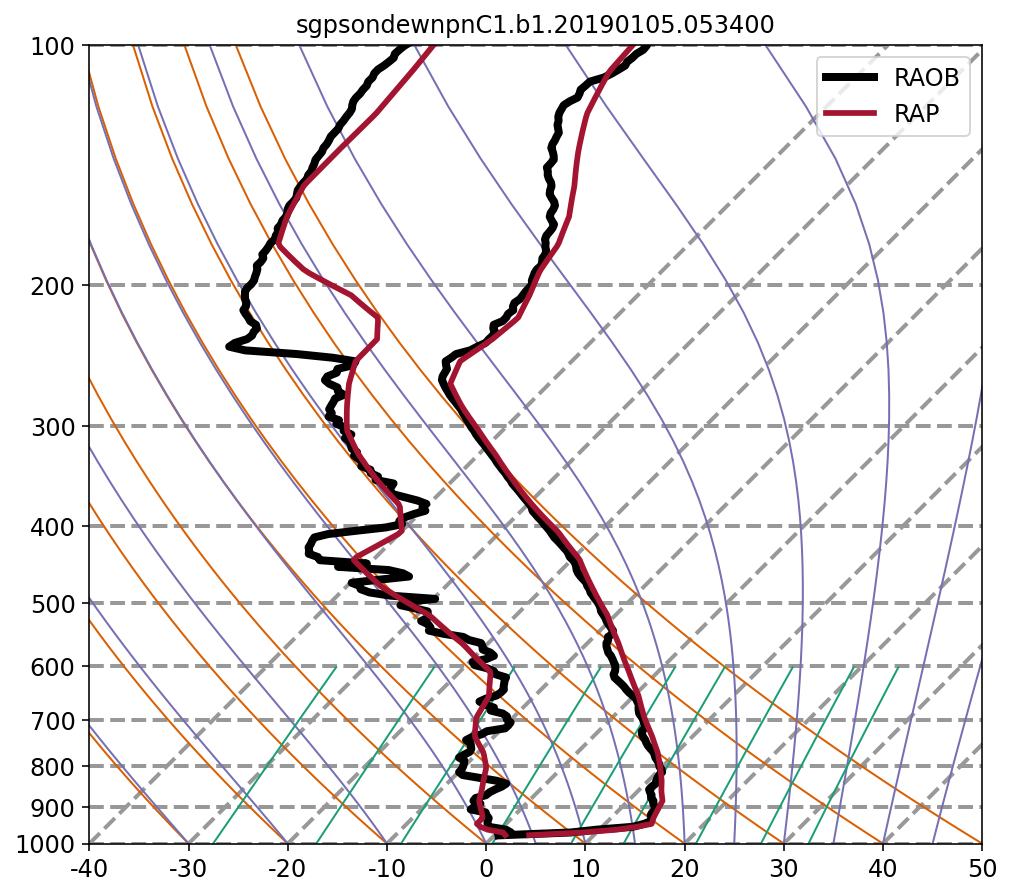

In [8]:
index = 5
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,dl.TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,dl.DEWPOINT]

title = sonde_files[index].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

# RAP

- [Linear](#Linear-NN)
- [Fully Connected](#Fully-Connected-NN)
- [Conv1D NN](#Conv1D-NN)
- [CAE NN](#CAE-NN)
- [Transfer Learning RAOB](#Transfer-Learning-RAOB)

## Linear NN

### Temperature

In [10]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8, 0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[dl.TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[dl.TEMPERATURE]].reshape(Ttest.shape[0],-1)

# Flatten inputs to (n, 4) and (n, 1) vectors
# input_dims = [PRESSURE, TEMPERATURE, DEWPOINT, ALTITUDE]
# Xt = Xtrain[:,:,input_dims]
# Xt = Xt.reshape(-1, Xt.shape[-1])
# Tt = Ttrain[:,:,[TEMPERATURE]]
# Tt = Tt.reshape(-1, Tt.shape[-1])
# Xe = Xtest[:,:,input_dims]
# Xe = Xe.reshape(-1, Xe.shape[-1])
# Te = Ttest[:,:,[TEMPERATURE]]
# Te = Te.reshape(-1, Te.shape[-1])

Xt.shape, Tt.shape, Xe.shape, Te.shape

((1026, 512), (1026, 256), (257, 512), (257, 256))

In [11]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

nnet.model.summary()

nnet.train(Xt, Tt, 50, 32, method='adam', verbose=True, 
           learning_rate=0.0001, validation=[Xe, Te])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________
epoch: 0, rmse 6.16221, val_rmse 4.96372
epoch: 5, rmse 2.41424, val_rmse 2.50502
epoch: 10, rmse 1.84095, val_rmse 1.92101
epoch: 15, rmse 1.58542, val_rmse 1.62825
epoch: 20, rmse 1.44432, val_rmse 1.46233
epoch: 25, rmse 1.33503, val_rmse 1.35676
epoch: 30, rmse 1.28714, val_rmse 1.28050
epoch: 35, rmse 1.23299, val_rmse 1.22189
epoch: 40, rmse 1.20291, val_rmse 1.18092
epoch: 45, rmse 1.16891, val_rmse 1.15652
epoch: 49, rmse 1.14541, val_rmse 1.14278
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.06512 in 4.5443 seconds.

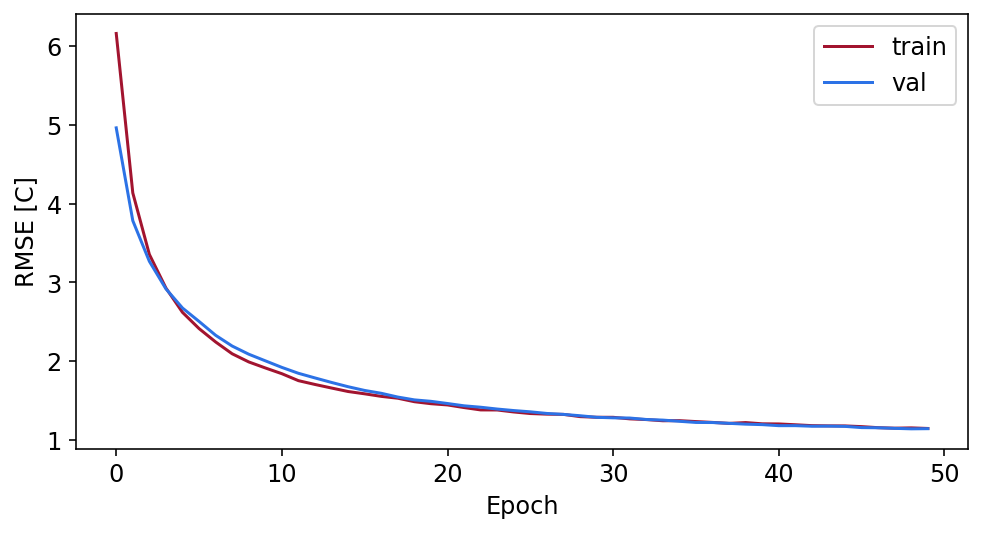

In [12]:
results.plot_loss(nnet)

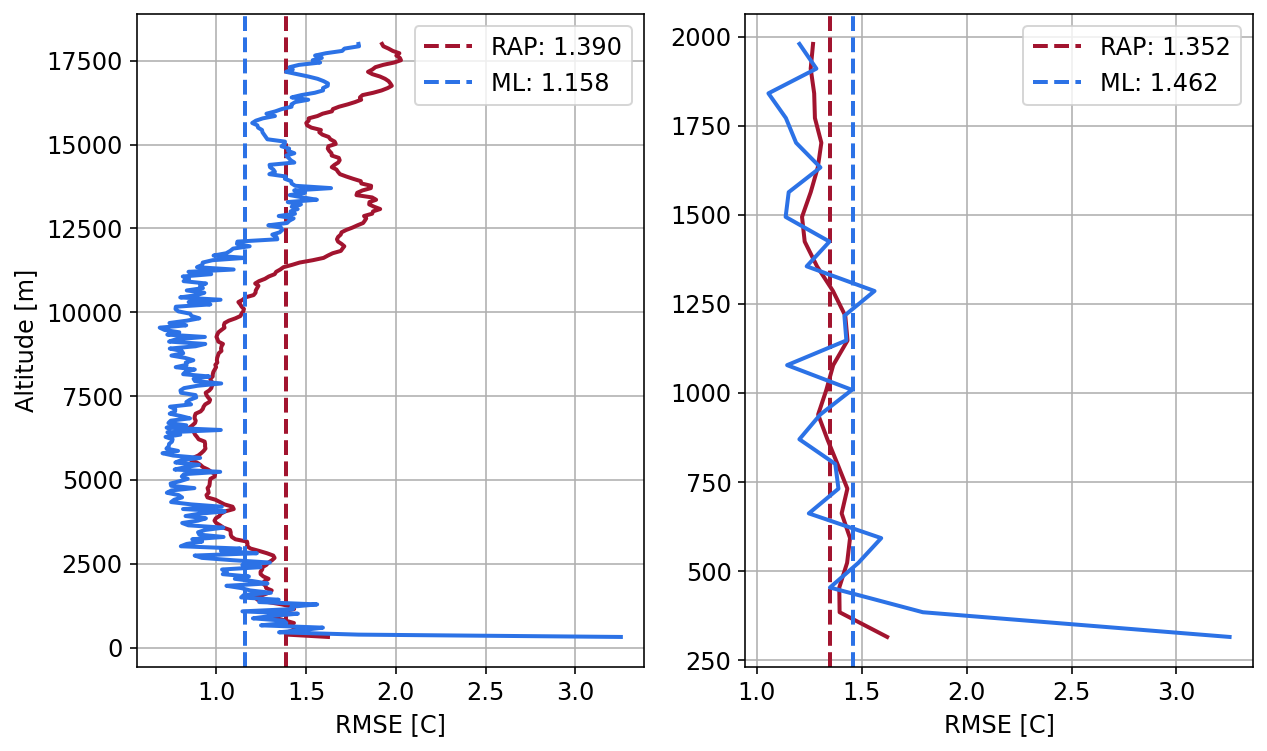

In [13]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])

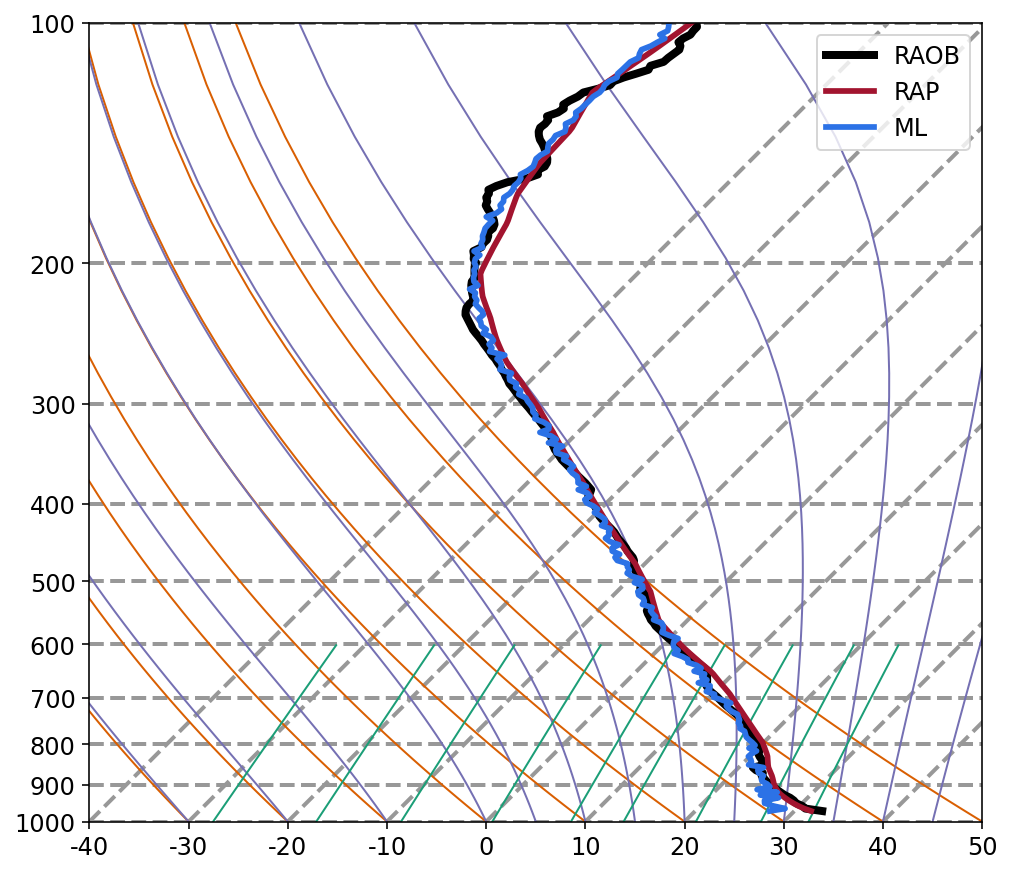

In [14]:
i = 11
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [15]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[dl.DEWPOINT]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[dl.DEWPOINT]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((1026, 512), (1026, 256), (257, 512), (257, 256))

In [16]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

# nnet.model.summary()

nnet.train(Xt, Tt, 50, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

epoch: 0, rmse 7.18426, val_rmse 5.21541
epoch: 5, rmse 4.11318, val_rmse 4.10166
epoch: 10, rmse 4.05034, val_rmse 4.00481
epoch: 15, rmse 4.11325, val_rmse 3.98300
epoch: 20, rmse 4.00335, val_rmse 4.10300
epoch: 25, rmse 3.99712, val_rmse 4.21545
epoch: 30, rmse 3.94755, val_rmse 3.88600
epoch: 35, rmse 3.95334, val_rmse 3.96296
epoch: 40, rmse 3.98814, val_rmse 3.95622
epoch: 45, rmse 4.03165, val_rmse 4.01923
epoch: 49, rmse 4.07442, val_rmse 4.03292
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.34936 in 3.7494 seconds.

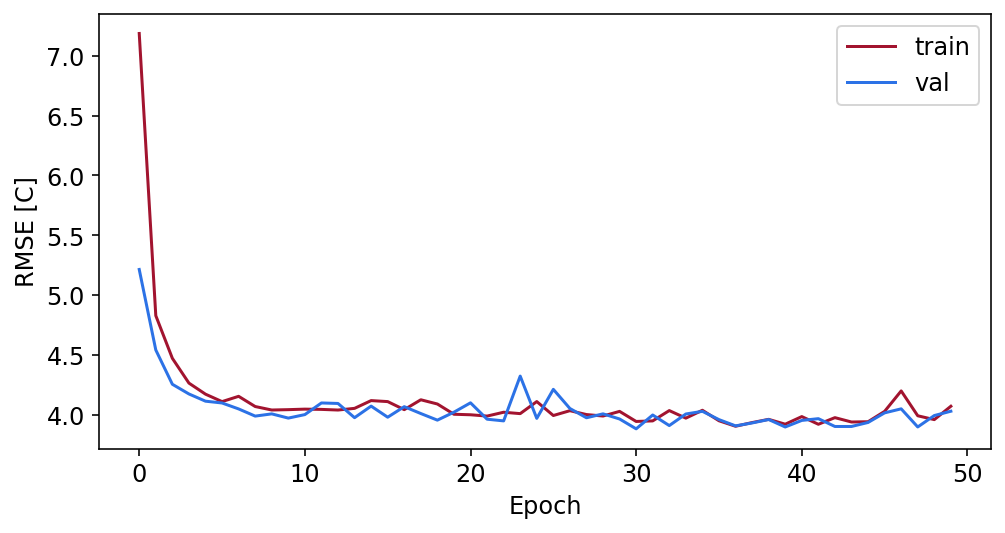

In [18]:
results.plot_loss(nnet)

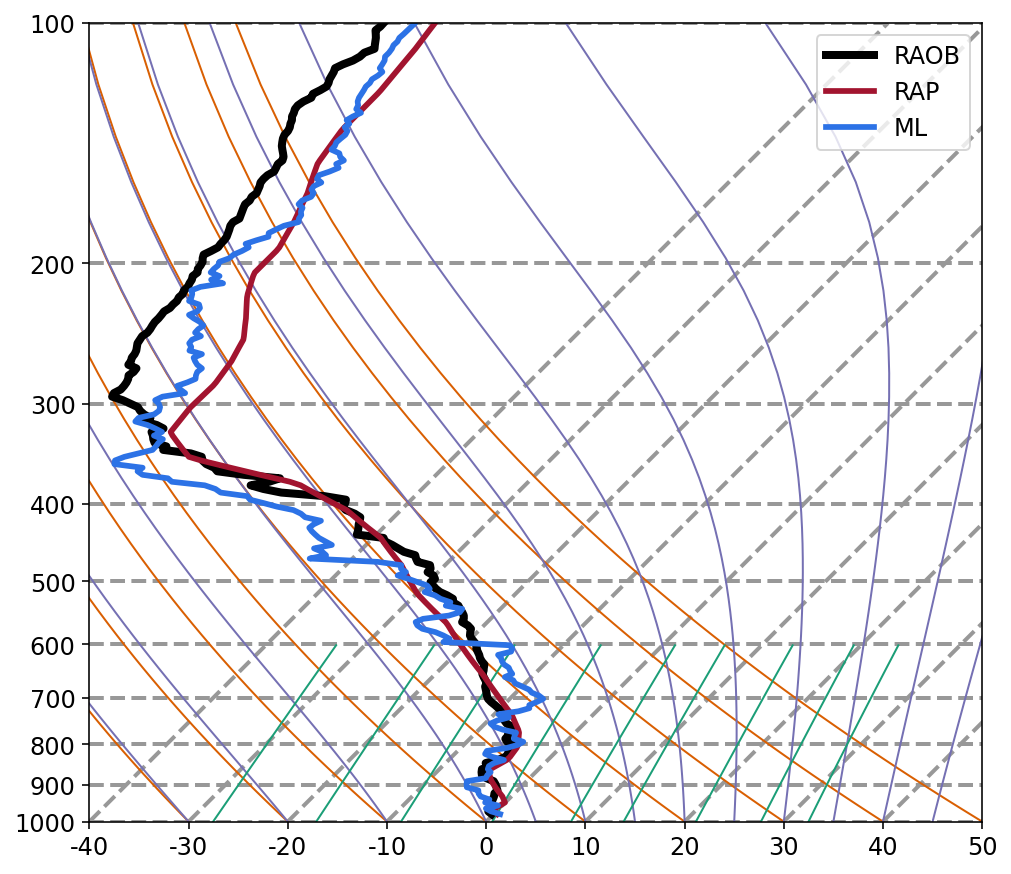

In [19]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

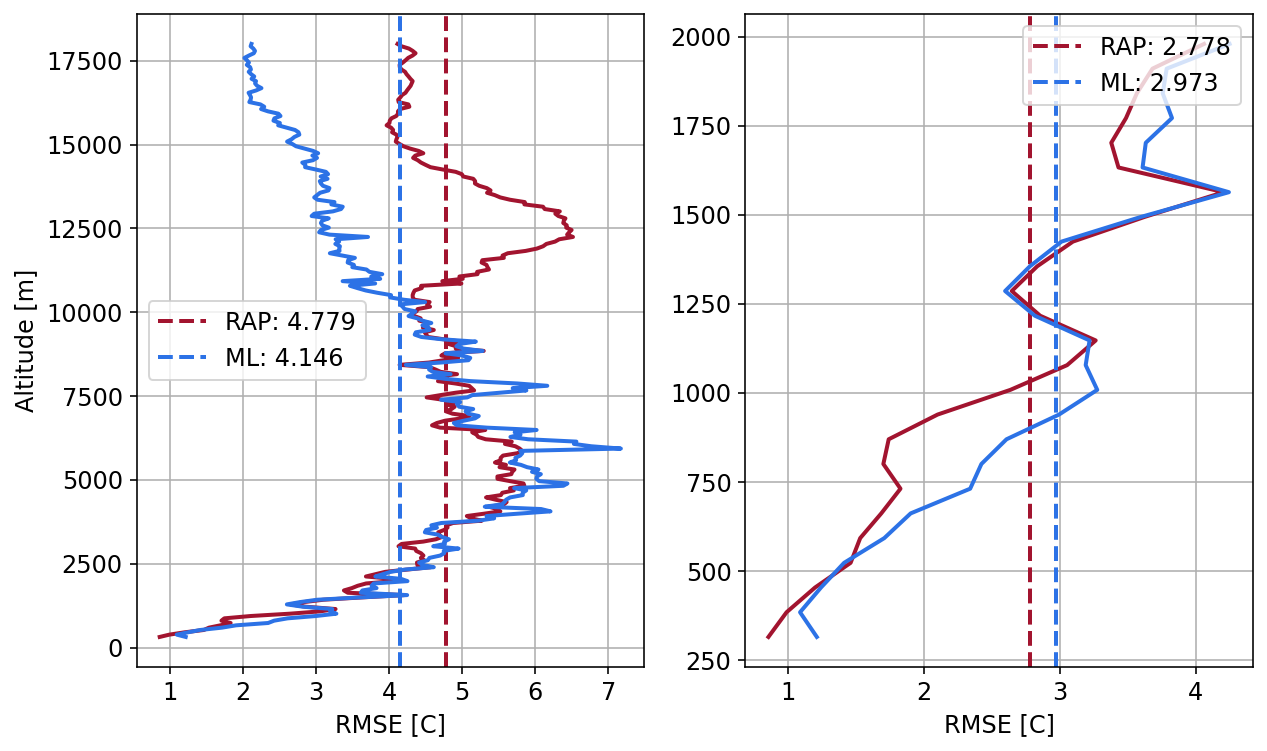

In [21]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.DEWPOINT], alt=raob[0, :, -1])

## Fully Connected NN

### Temperature

In [16]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[dl.TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[dl.TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((1026, 256), (1026, 256), (257, 256), (257, 256))

FloatProgress(value=0.0, max=8.0)

{'epochs': 100, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [16, 16]}


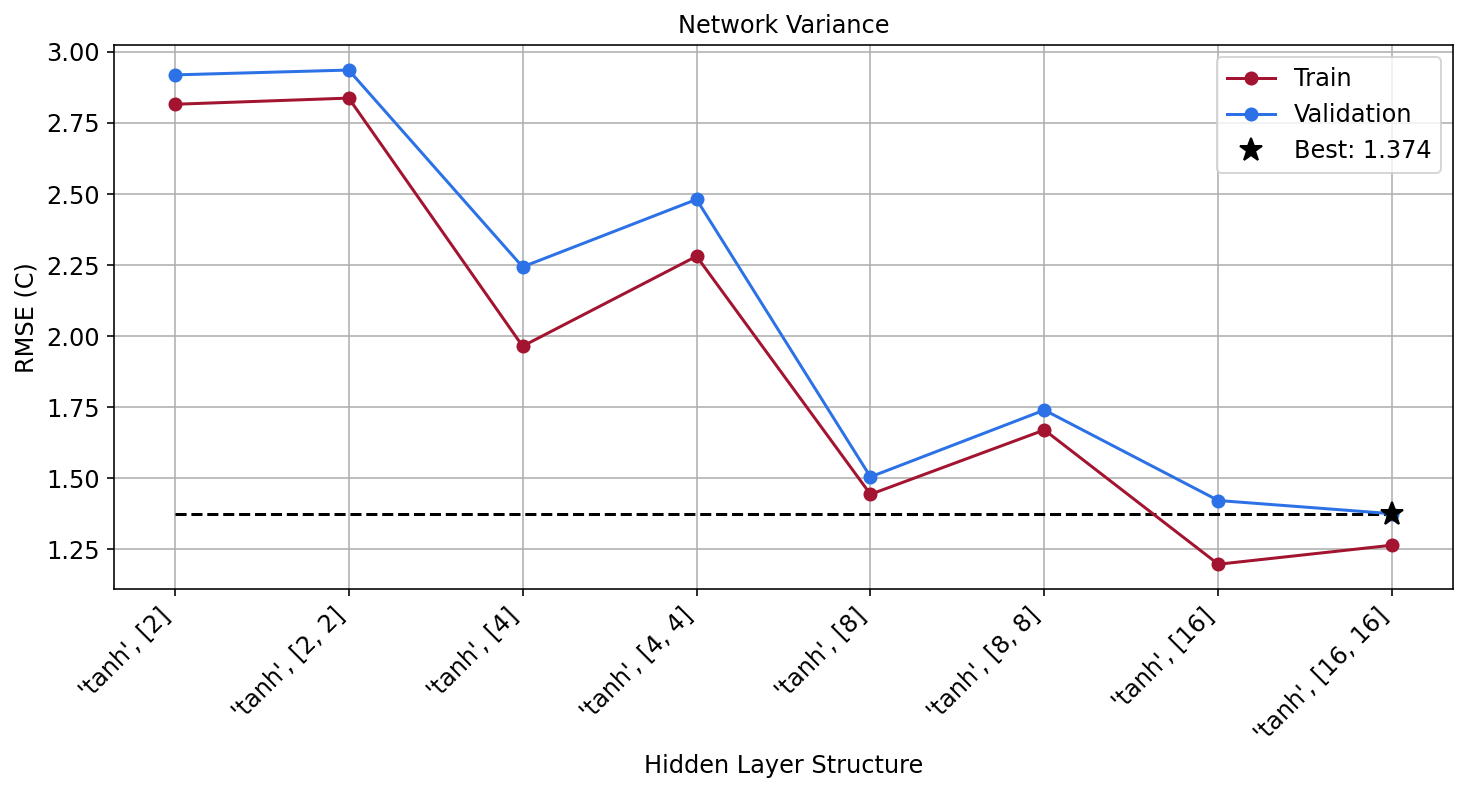

In [17]:
activations = ['tanh']
layers = [[nu] * nl for nu in [2, 4, 8, 16] for nl in range(1, 3)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.NeuralNetwork, product, Xt, Tt, Xe, Te,
                                   epochs=100, batch_size=32, method='adam', lr=0.001, verbose=False)
plot_param_search(product, train_history, val_history, rotation=45)

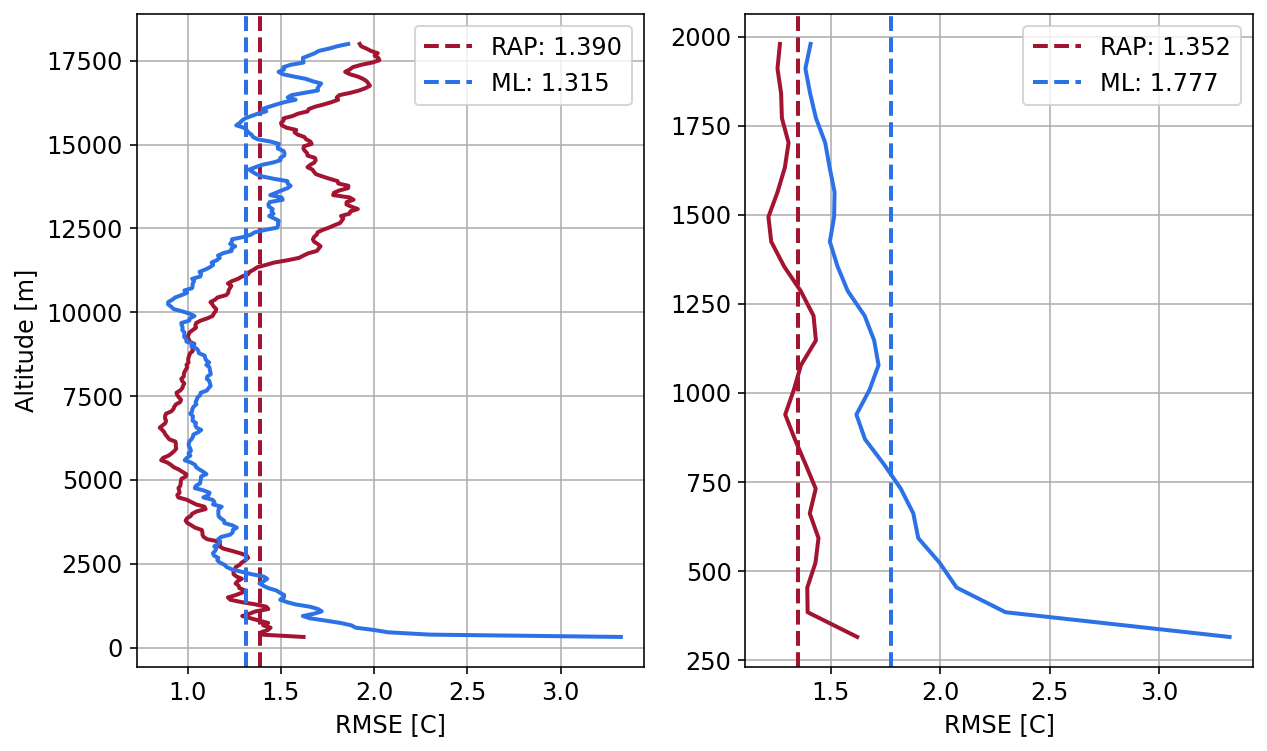

In [18]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])

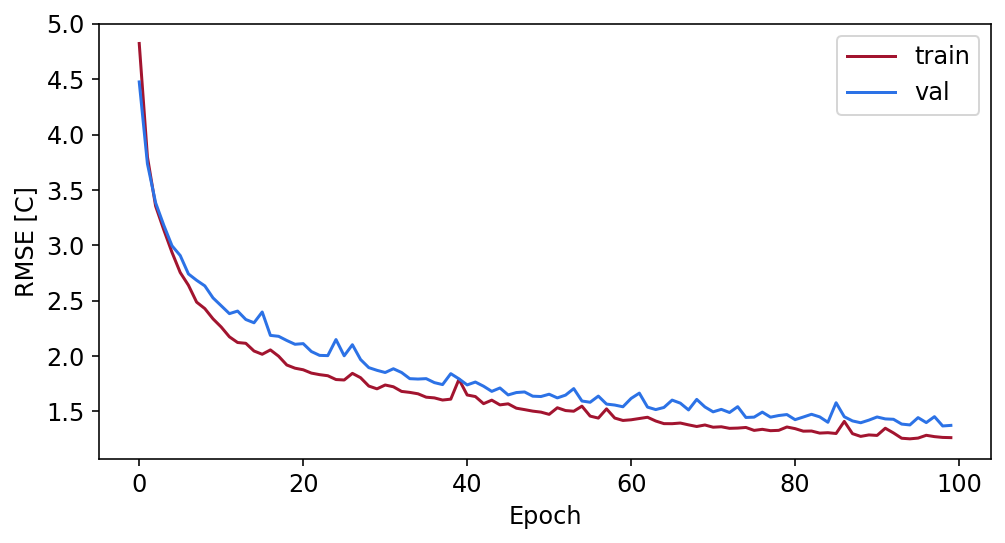

In [19]:
results.plot_loss(nnet)

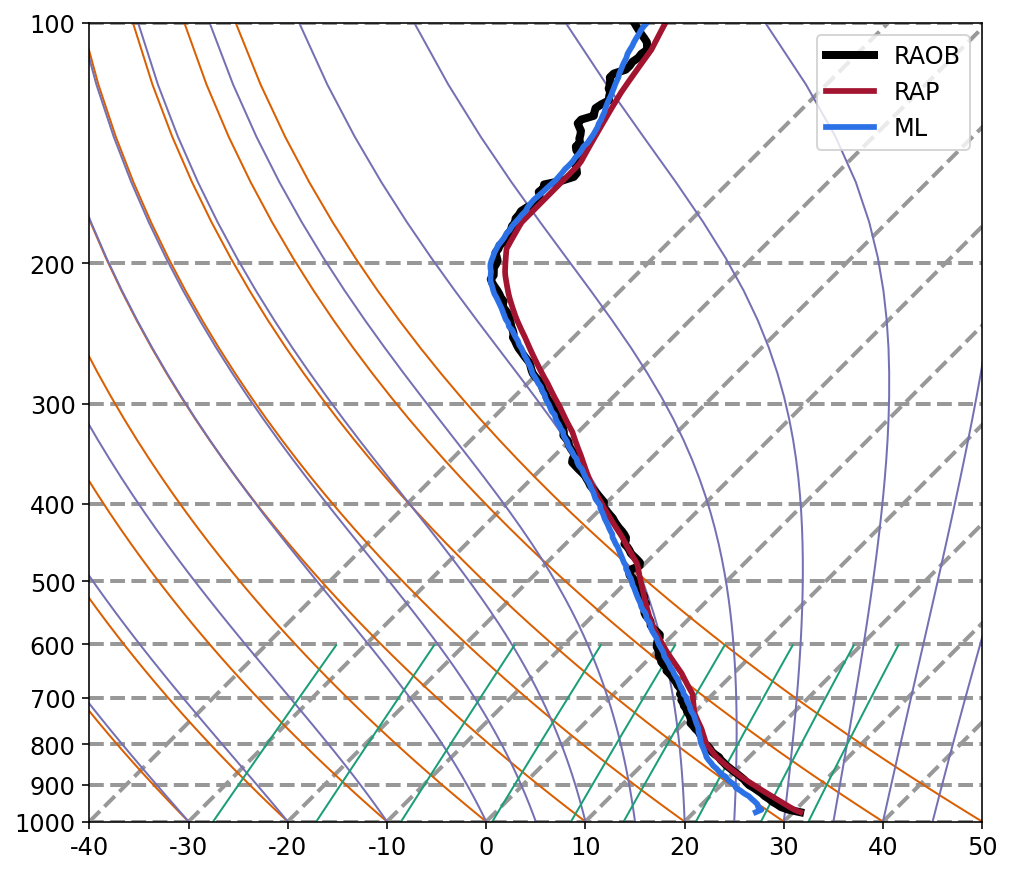

In [20]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [27]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[dl.DEWPOINT]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[dl.DEWPOINT]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((1026, 512), (1026, 256), (257, 512), (257, 256))

FloatProgress(value=0.0, max=18.0)

{'epochs': 50, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'relu', 'layers': [128]}


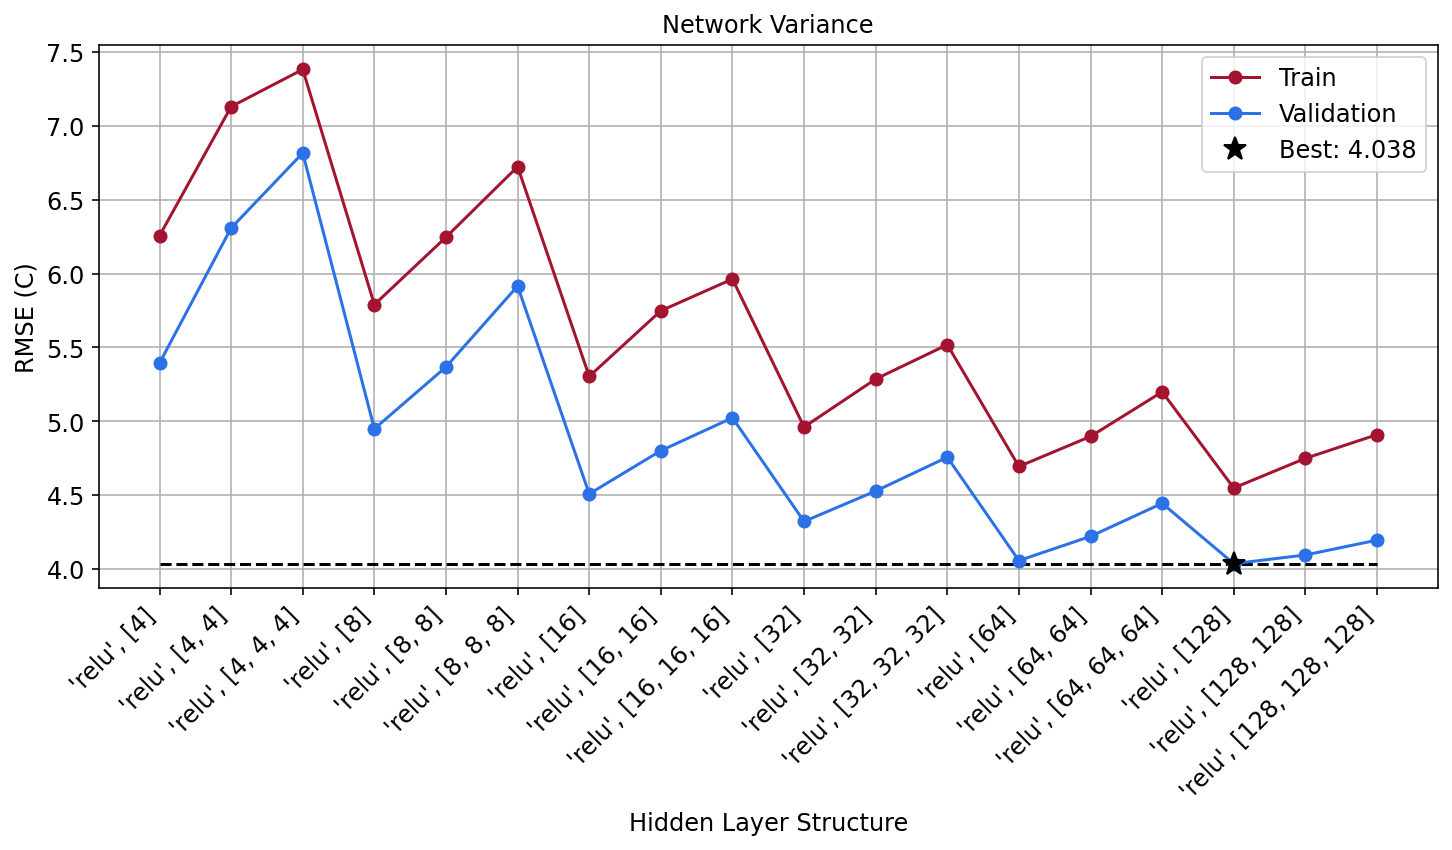

In [28]:
activations = ['relu']
layers = [[nu] * nl for nu in [4, 8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.NeuralNetwork, product, Xt, Tt, Xe, Te,
                                   epochs=50, batch_size=32, method='adam', lr=0.001, verbose=False)
plot_param_search(product, train_history, val_history, rotation=45)

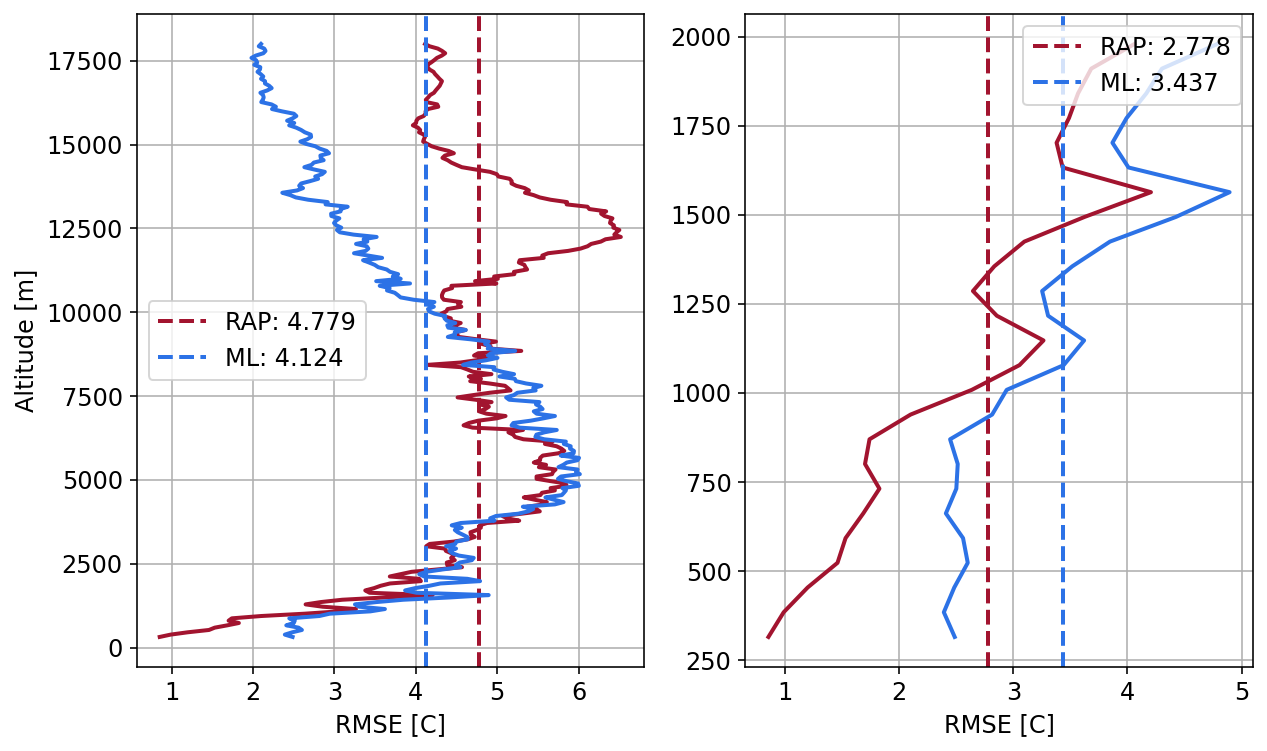

In [29]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.DEWPOINT], alt=raob[0, :, -1])

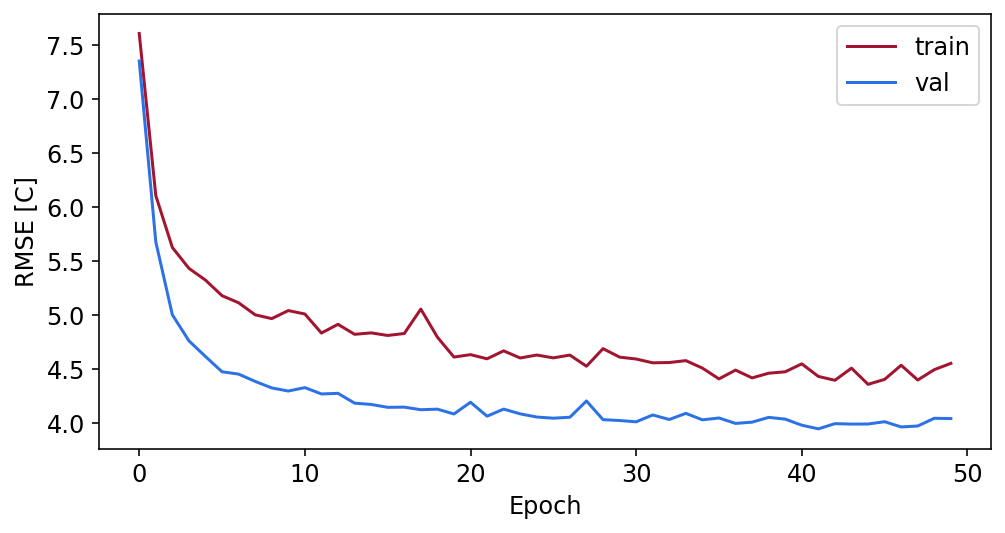

In [30]:
results.plot_loss(nnet)

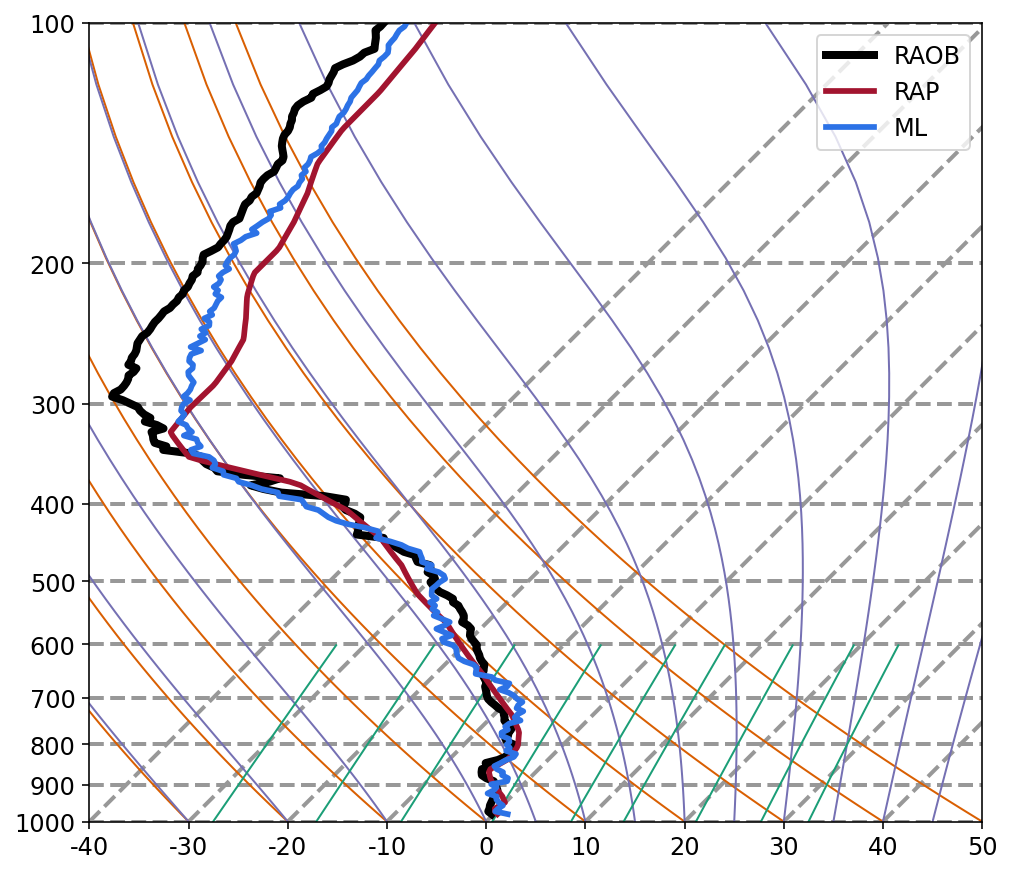

In [31]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Conv1D NN

### Temperature

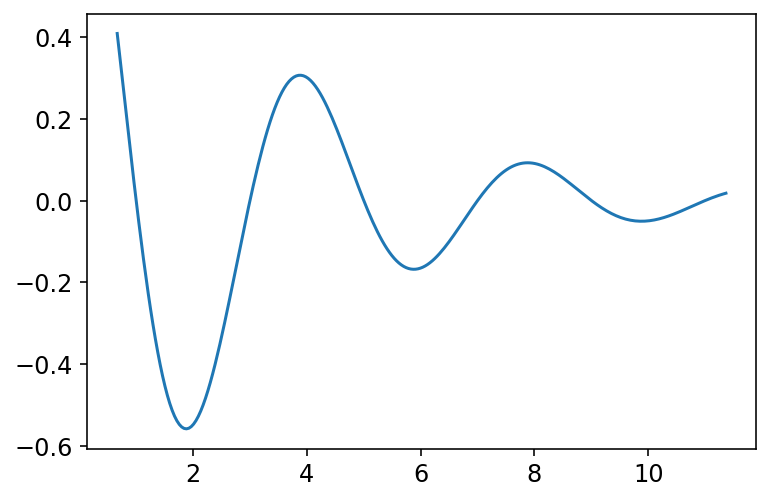

In [204]:
x = np.linspace(np.random.uniform(-4, 4), np.random.uniform(5, 15), 256)
deflection = np.random.randint(1, 5)
damping_coefficent = 0.3
w = 0.5*np.pi
el = deflection * np.exp(-x*damping_coefficent) * np.cos(w * x)
plt.plot(x, el)

In [182]:
def perturb(X, T, shuffle=True):
    temp = copy.copy(X)
    for i in range(len(temp)):
        x = np.linspace(np.random.uniform(-4, 4), np.random.uniform(9, 15), X.shape[1])
        deflection = np.random.randint(1, 5)
        damping_coefficent = 0.3
        w = 0.5*np.pi
        temp[i,:,dl.TEMPERATURE] += deflection * np.exp(-x*damping_coefficent) * np.cos(w * x)

    X = np.concatenate([X, temp])
    T = np.concatenate([T, T])
    
    if shuffle:
        rowIndices = np.arange(len(X))
        np.random.shuffle(rowIndices)
        X = X[rowIndices]
        T = T[rowIndices]
    
    return X, T

In [21]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

# for i in range(2):
#     Xtrain, Ttrain = perturb(Xtrain, Ttrain)

input_dims = [dl.TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE] # - Xtrain[:,:,dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE] # - Xtest[:,:,dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 1), (1026, 256), (257, 256, 1), (257, 256))

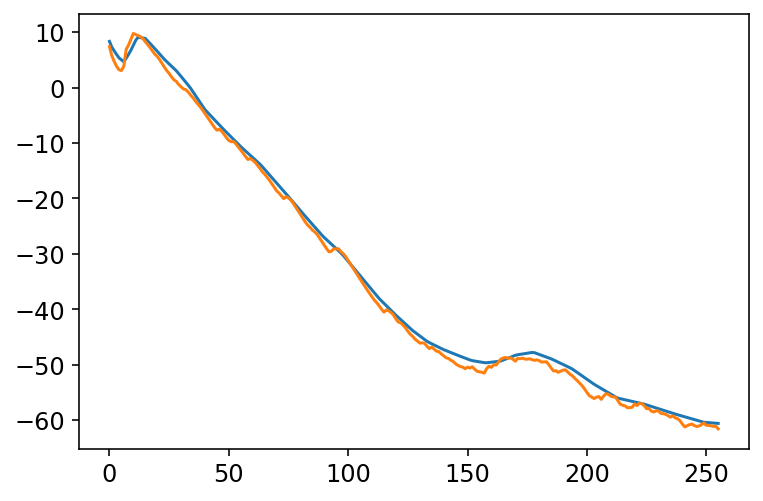

In [22]:
i = 6
plt.plot(Xtest[i, :, 0])
plt.plot(Ttest[i])

FloatProgress(value=0.0, max=17.0)

{'epochs': 30, 'batch_size': 64, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [128]}


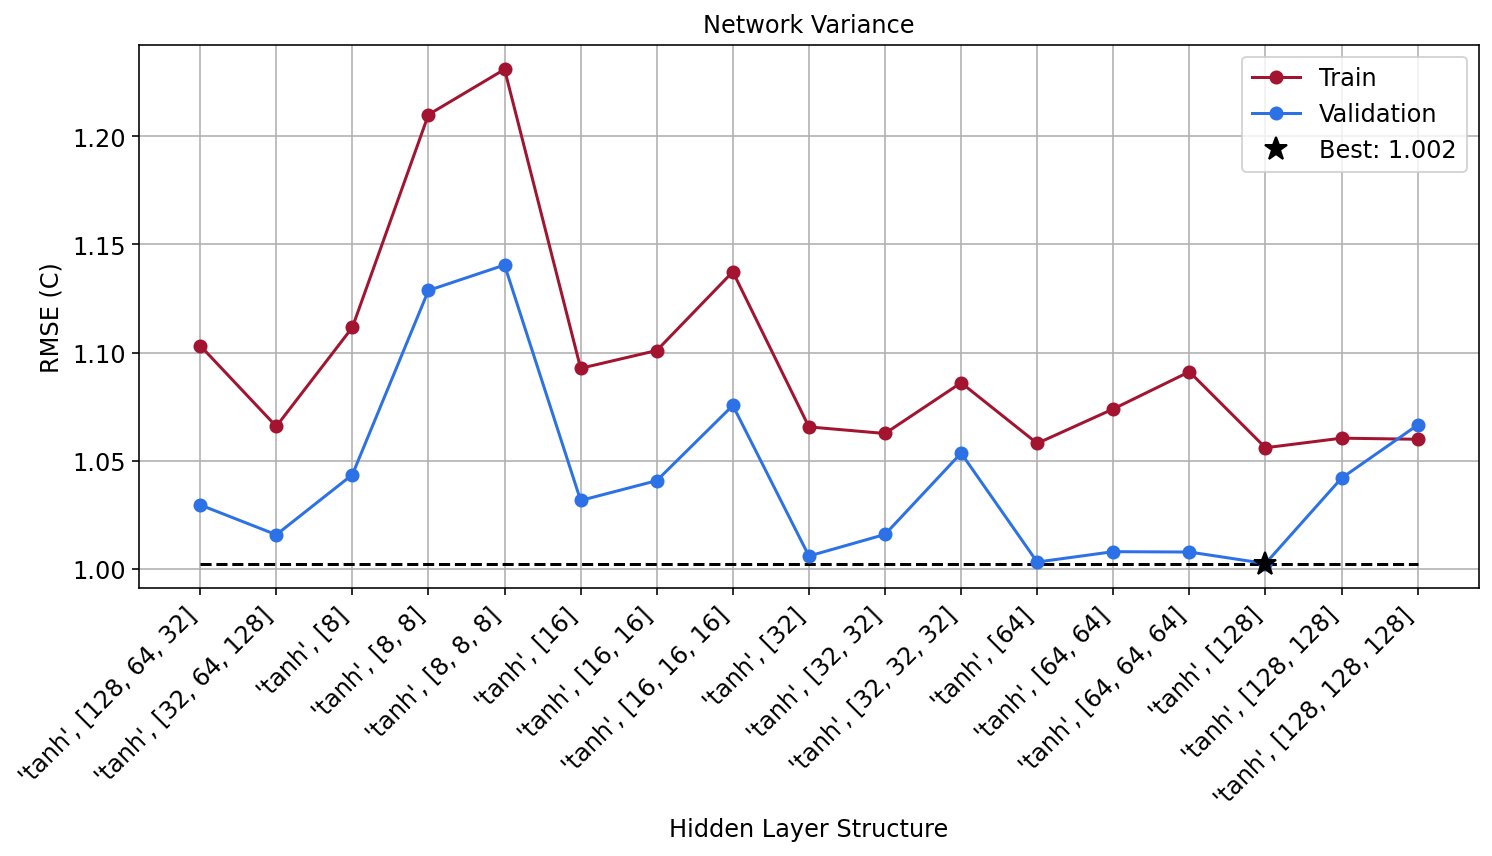

In [23]:
activations = ['tanh']
layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalNeuralNetwork, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=30, batch_size=64, method='adam', lr=0.001,
                                                kernels_size_and_stride=[[1, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

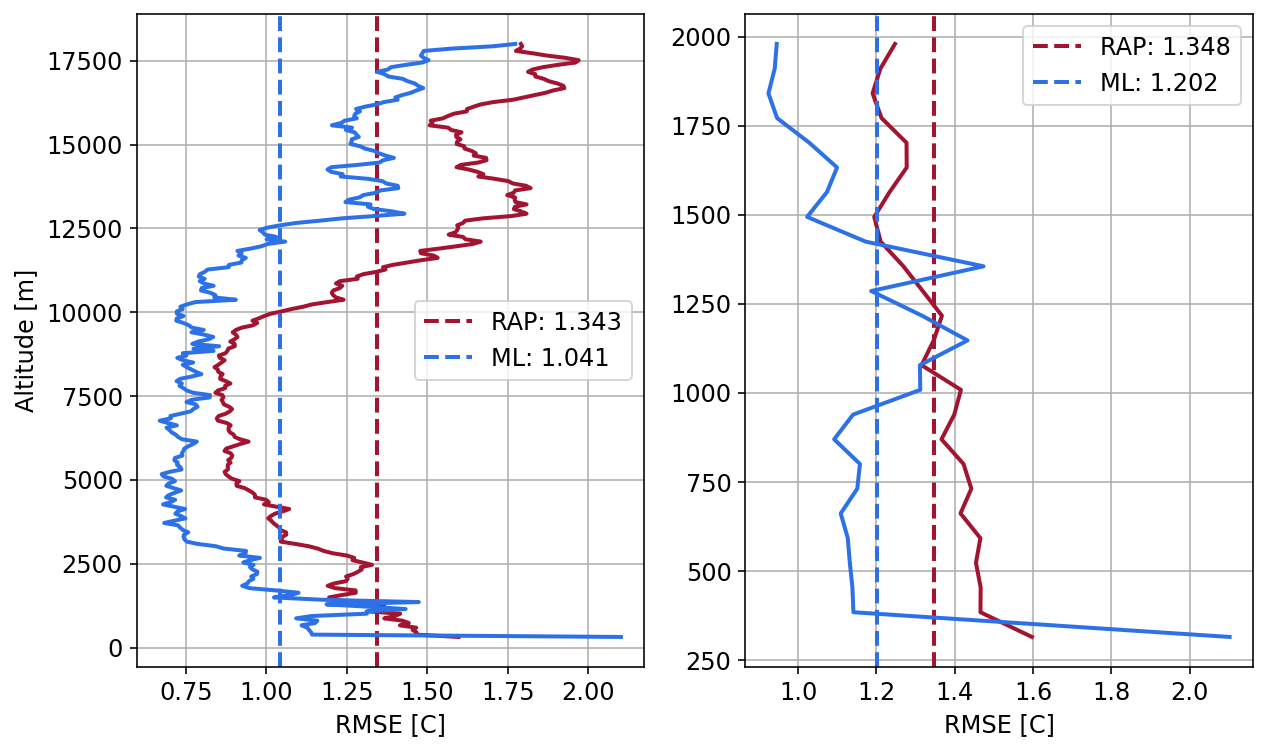

In [24]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,0], alt=raob[0,:,-1])

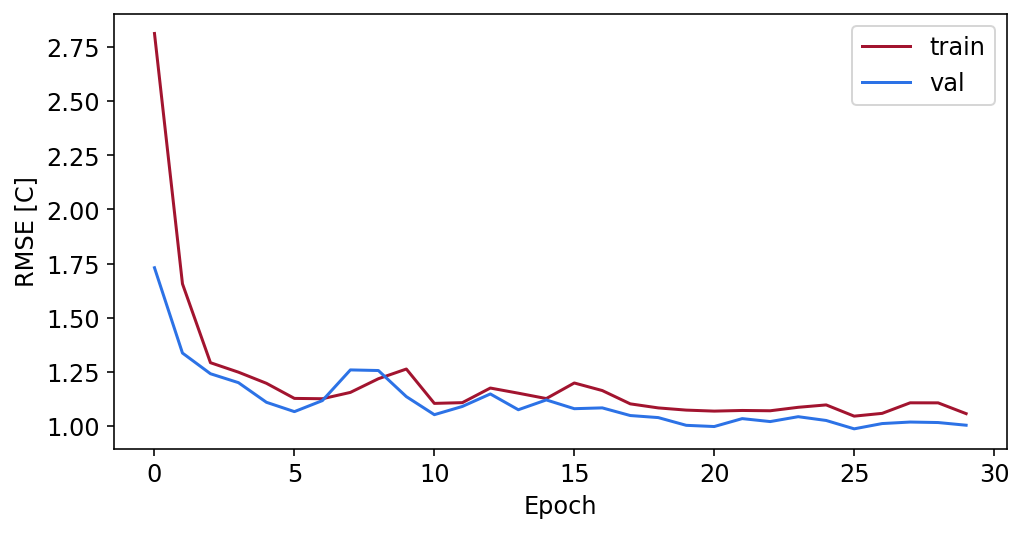

In [25]:
results.plot_loss(nnet)

In [ ]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i] # + Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE] 
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0] # + Xtest[i,:,dl.TEMPERATURE]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

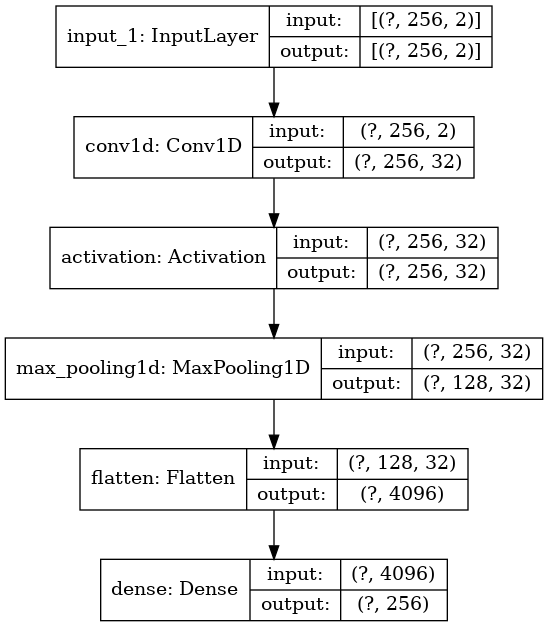

In [38]:
tf.keras.utils.plot_model(nnet.model, '/home/stock/research/media/rap_only_network.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

### Moisture

In [39]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

FloatProgress(value=0.0, max=17.0)

{'epochs': 25, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [16]}


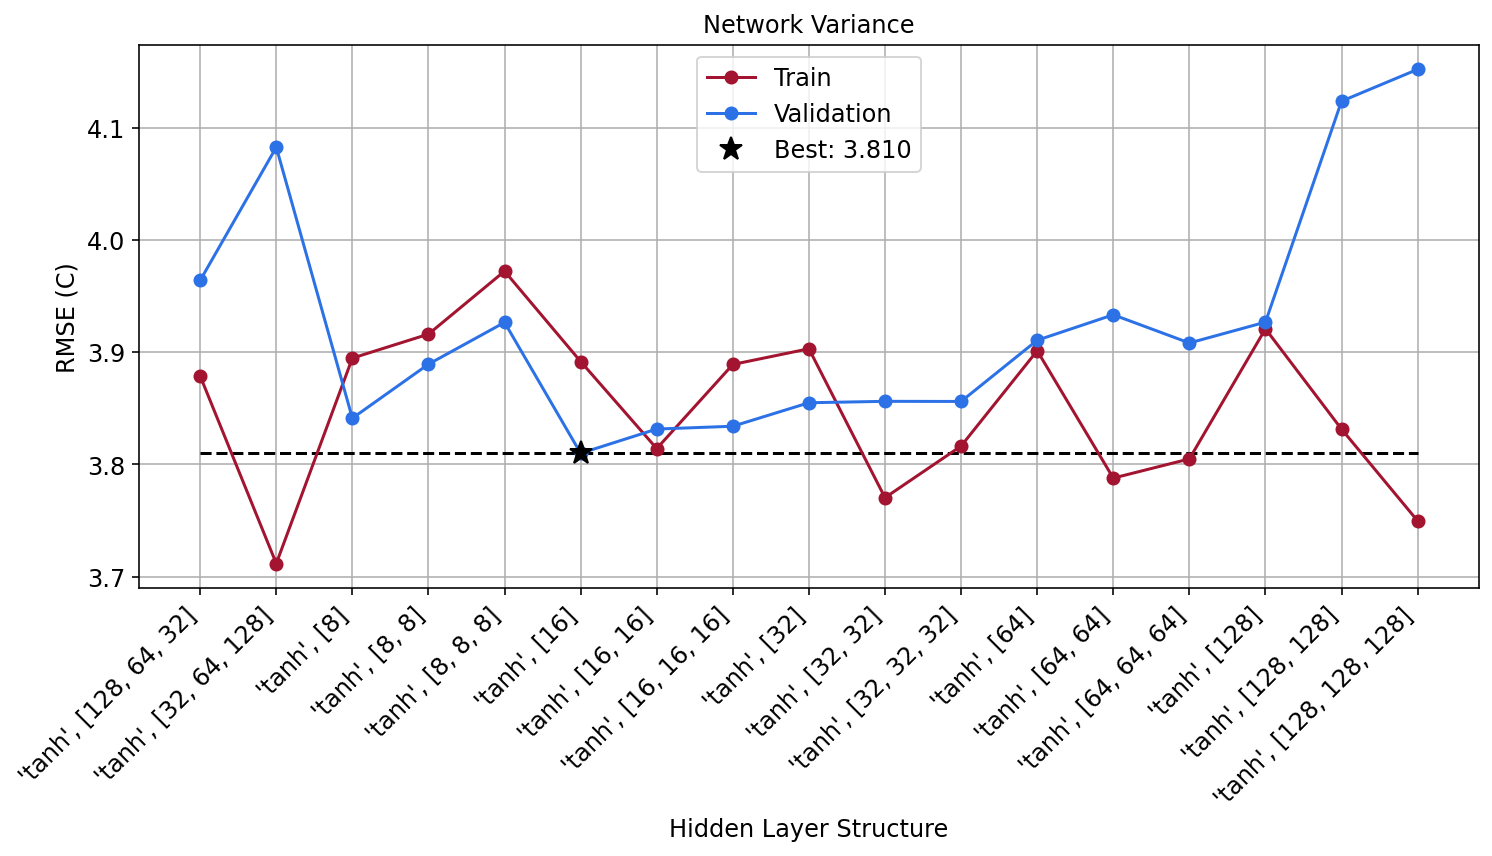

In [40]:
activations = ['tanh']
layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalNeuralNetwork, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=25, batch_size=32, method='adam', lr=0.001,
                                                kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

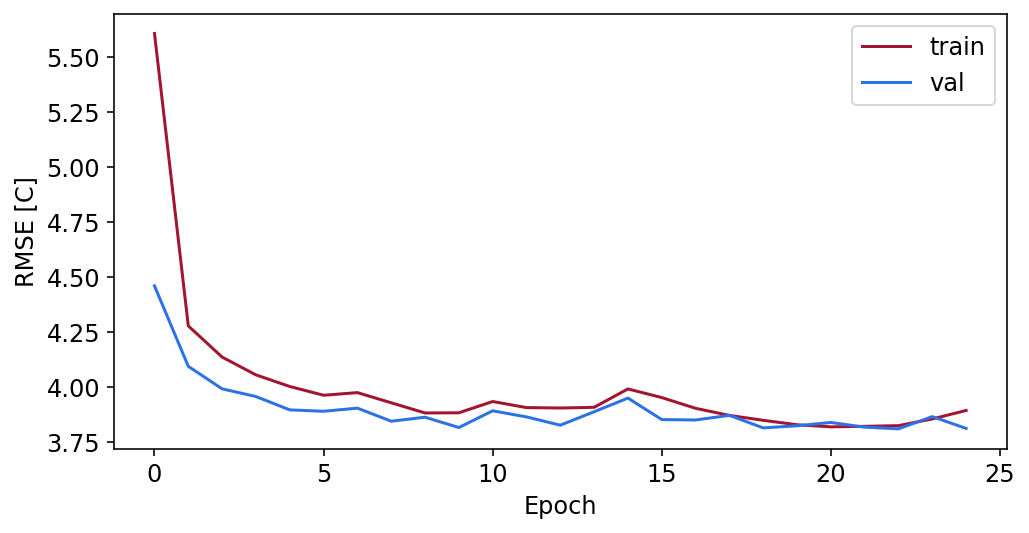

In [41]:
results.plot_loss(nnet)

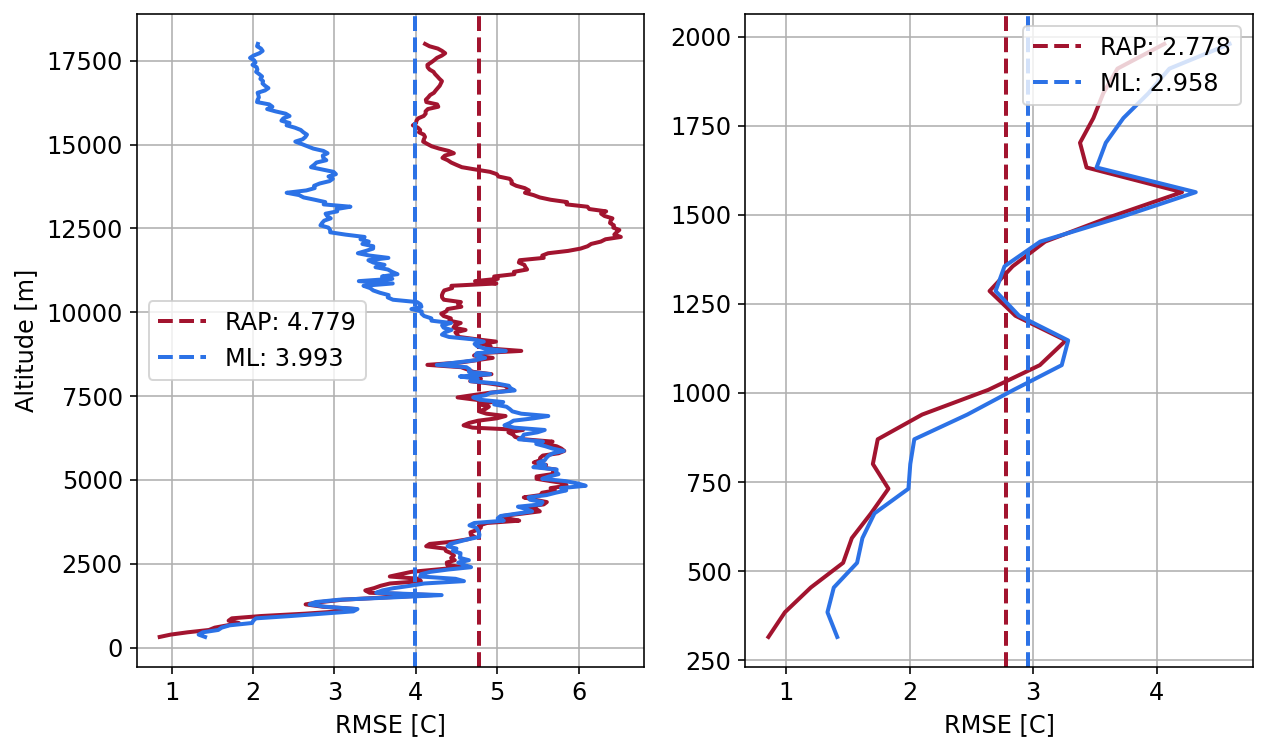

In [42]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])

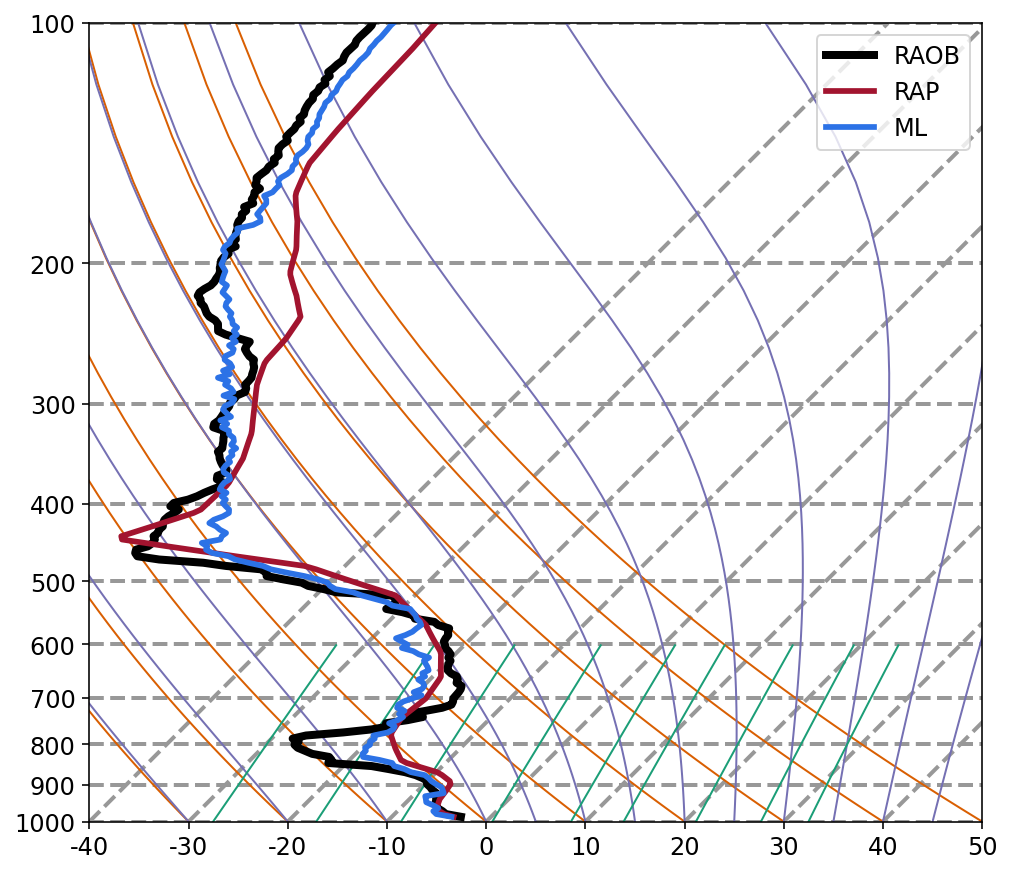

In [43]:
i = 0
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtrain[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtrain[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## CAE NN

### Temperature

In [26]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

FloatProgress(value=0.0, max=12.0)

{'epochs': 35, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [4]}


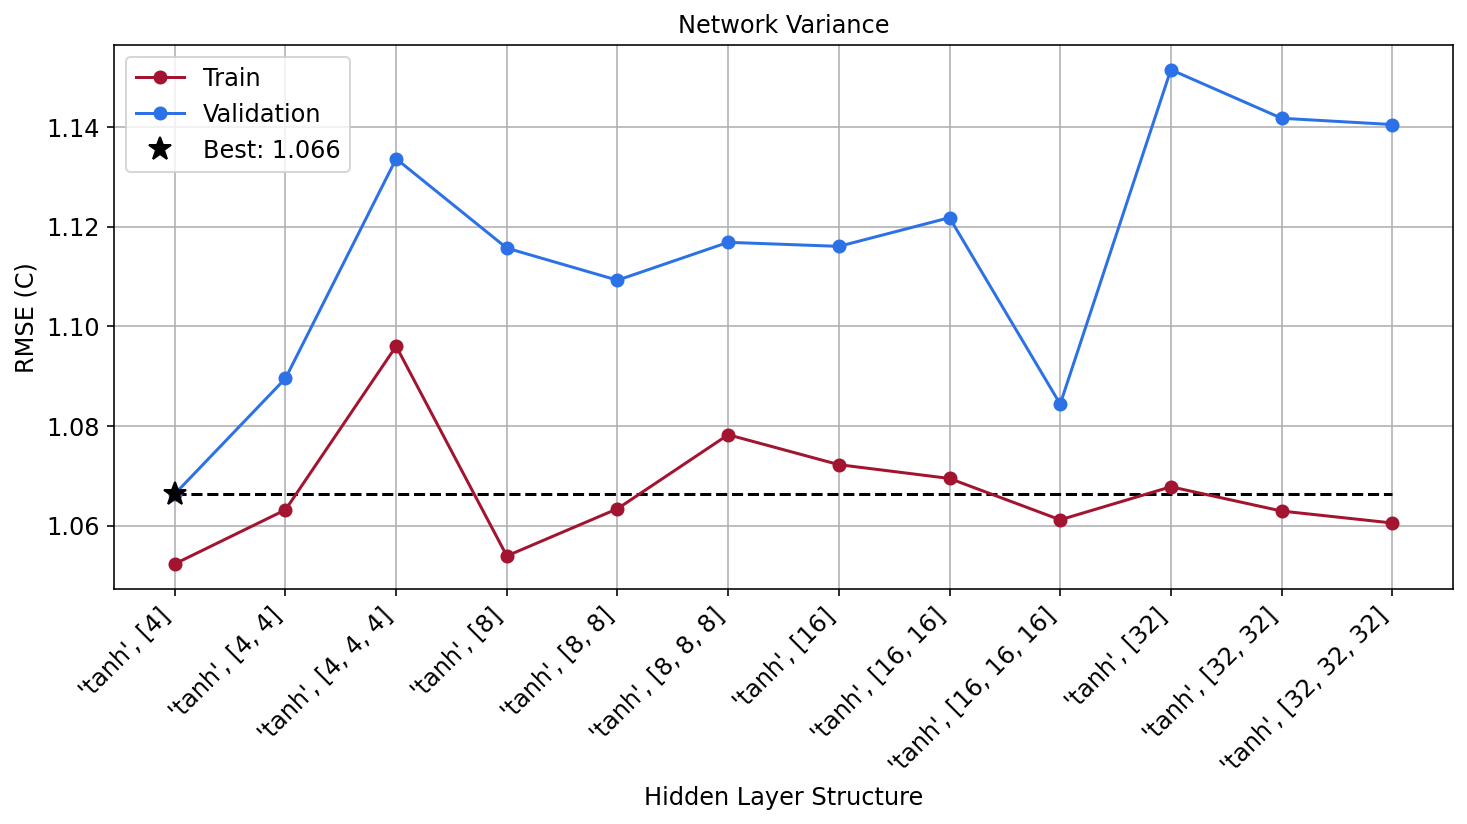

In [27]:
activations = ['tanh']
layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalAutoEncoder, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=35, batch_size=32, method='adam',
                                                lr=0.001, kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

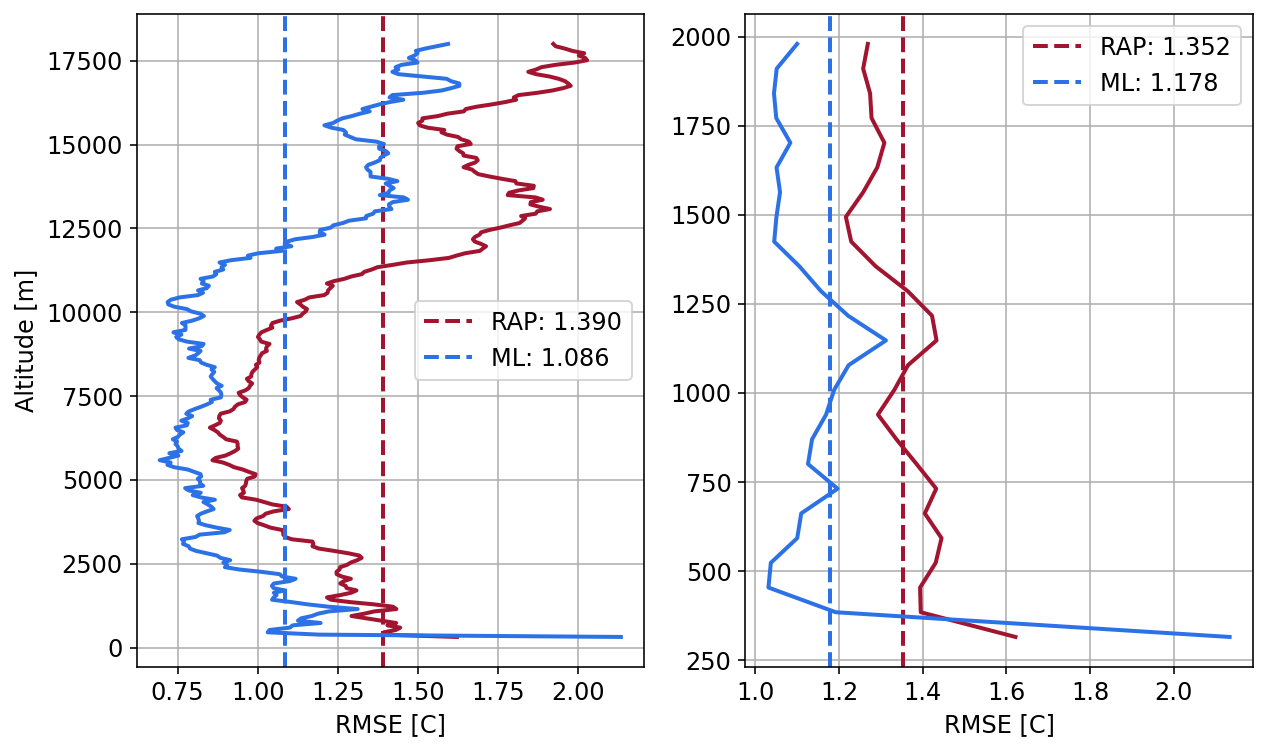

In [28]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

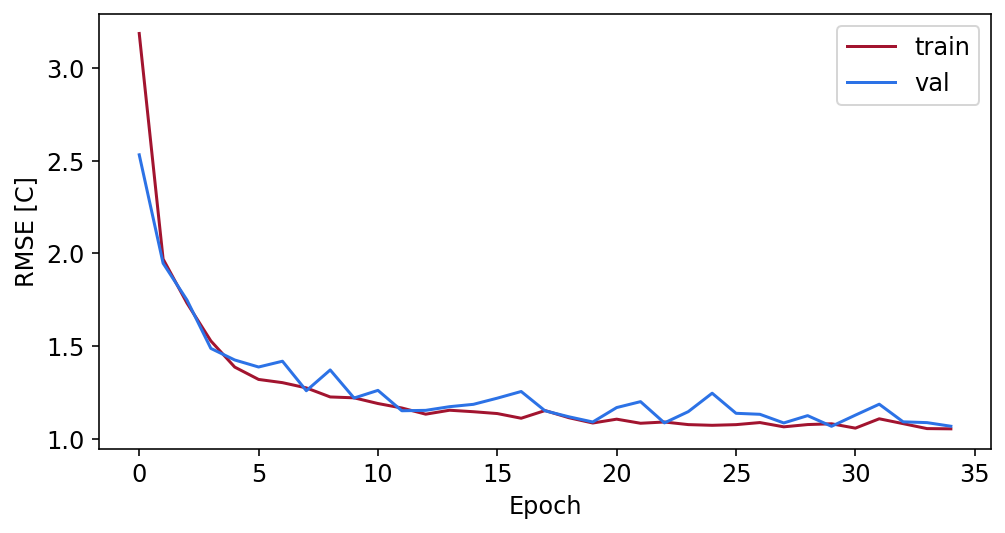

In [29]:
results.plot_loss(nnet)

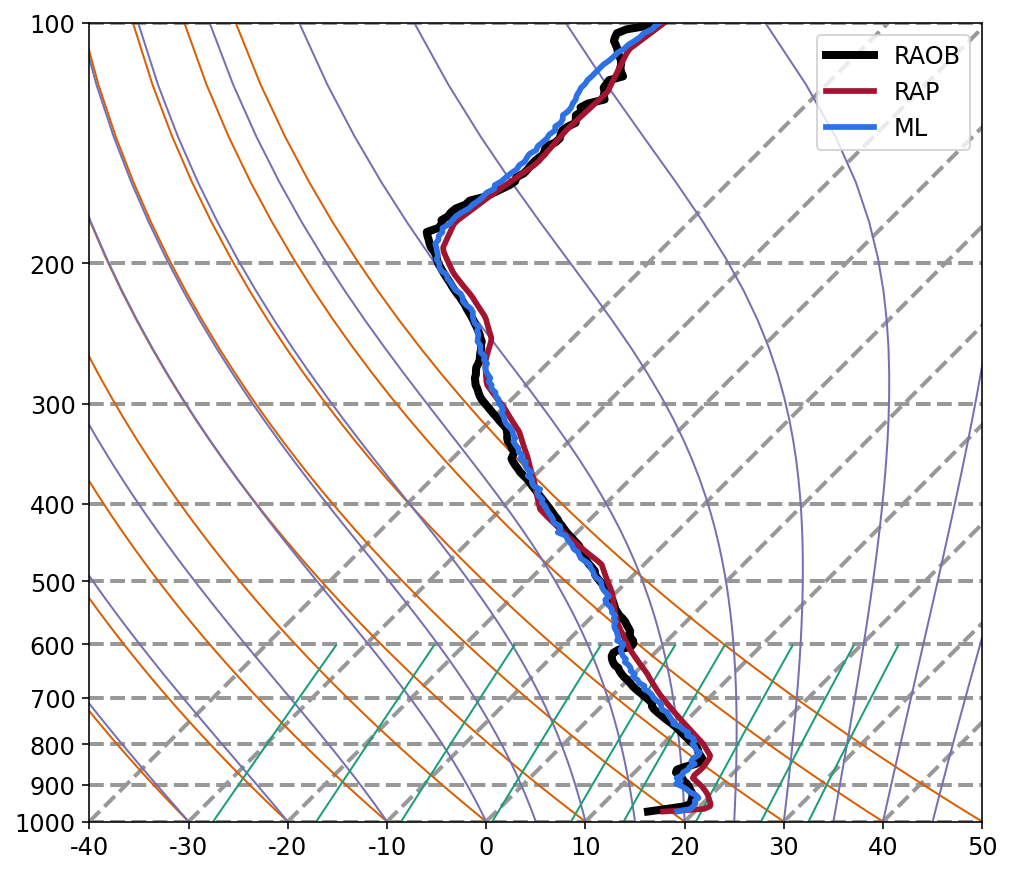

In [30]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [49]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

FloatProgress(value=0.0, max=12.0)

{'epochs': 35, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [4, 4, 4]}


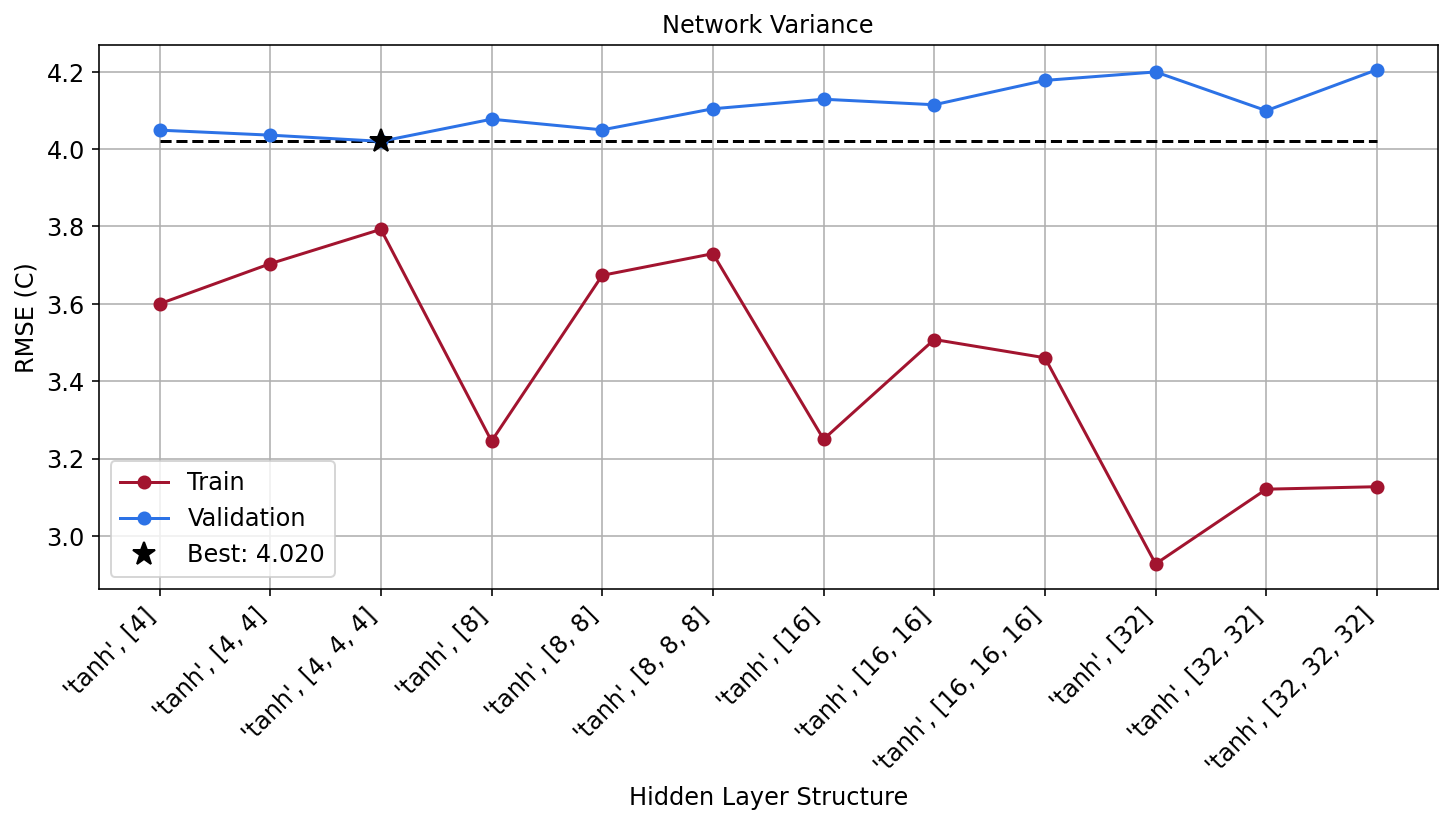

In [50]:
activations = ['tanh']
layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalAutoEncoder, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=35, batch_size=32, method='adam',
                                                lr=0.001, kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

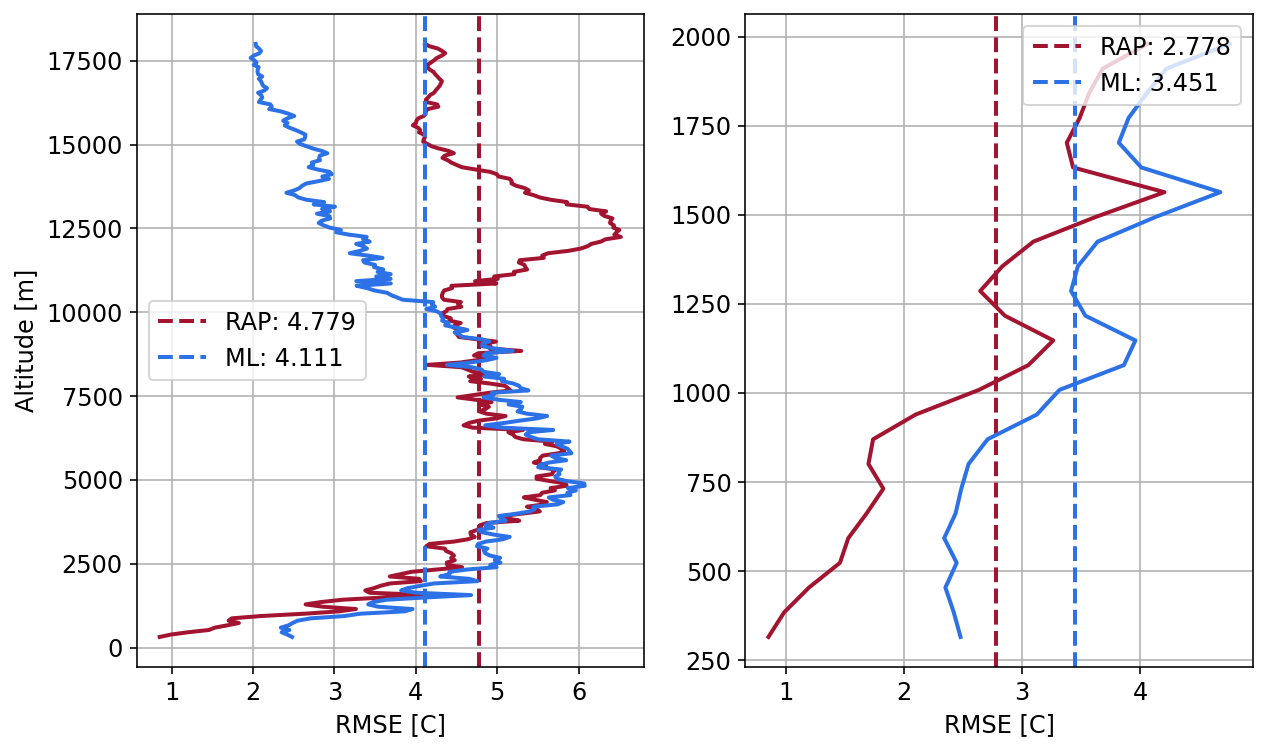

In [51]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

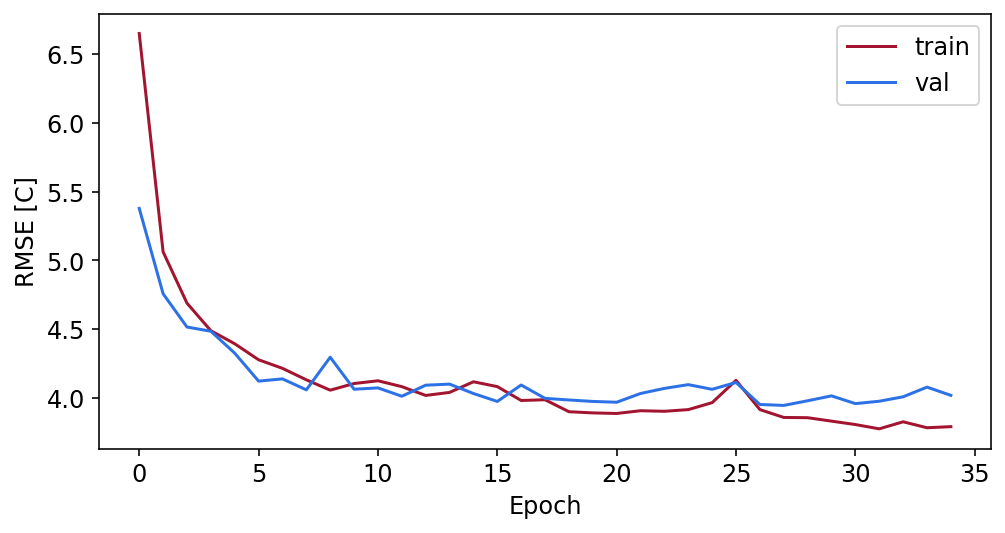

In [52]:
results.plot_loss(nnet)

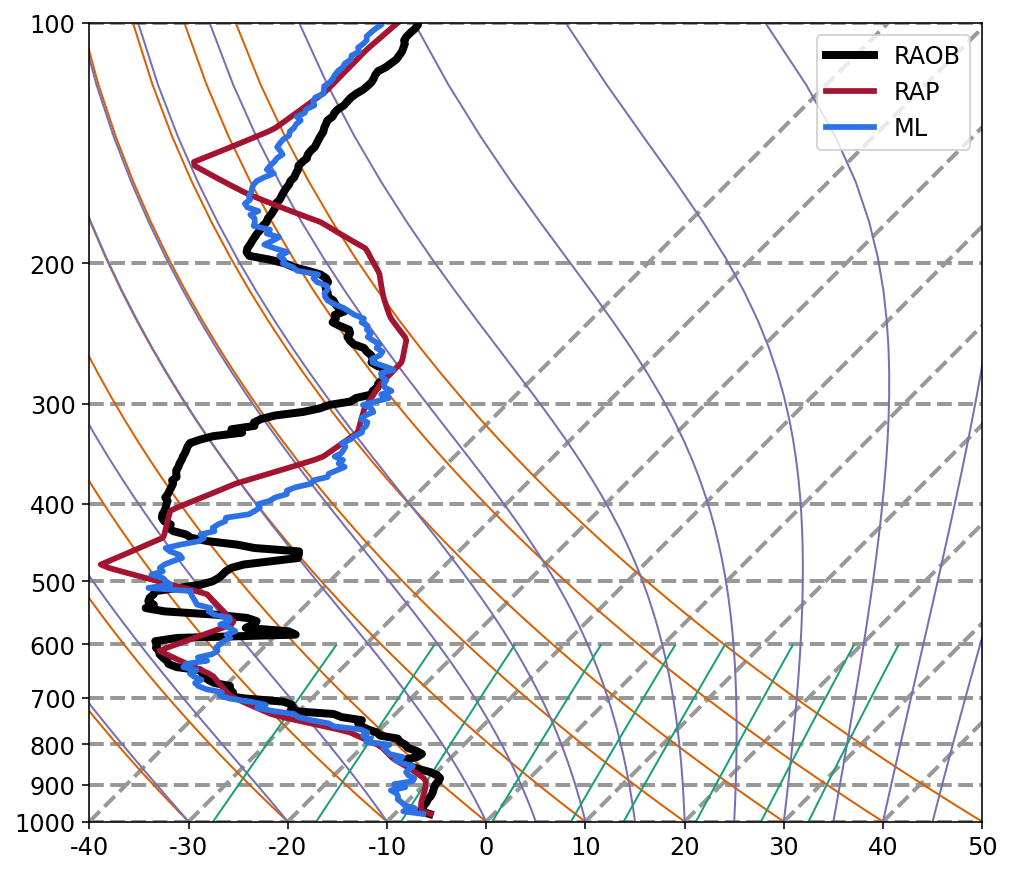

In [53]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## UNet Model

### Temperature

In [31]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

In [32]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [8, 8], [(10, 1)]*2,
                         Ttrain.shape[1], activation='tanh',
                         n_hidden_dims=32, seed=1234)
nnet.train(Xtrain, Ttrain, 35, 32, method='adam', verbose=False,
           learning_rate=0.001, validation=[Xtest, Ttest])

SkipNeuralNetwork((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.05538 in 18.7166 seconds.

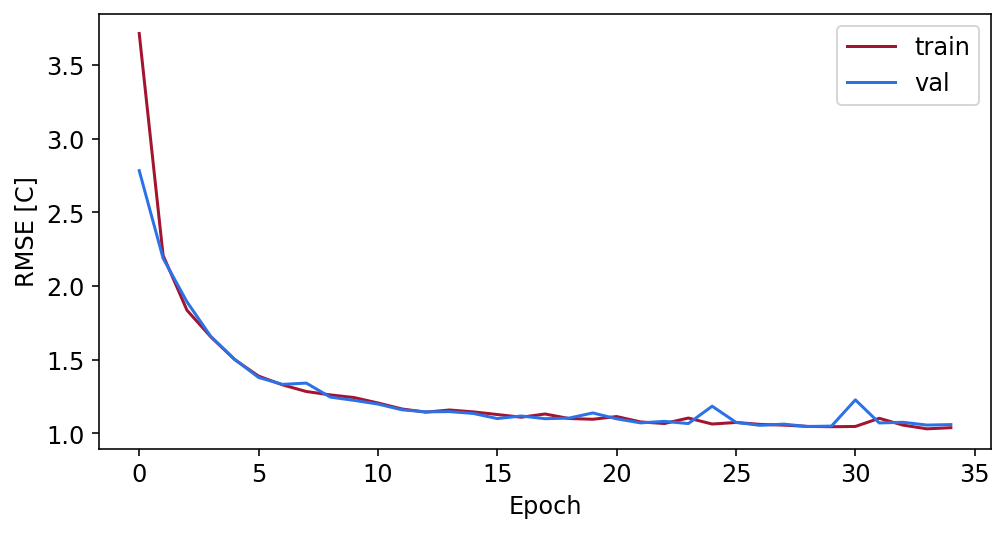

In [33]:
results.plot_loss(nnet)

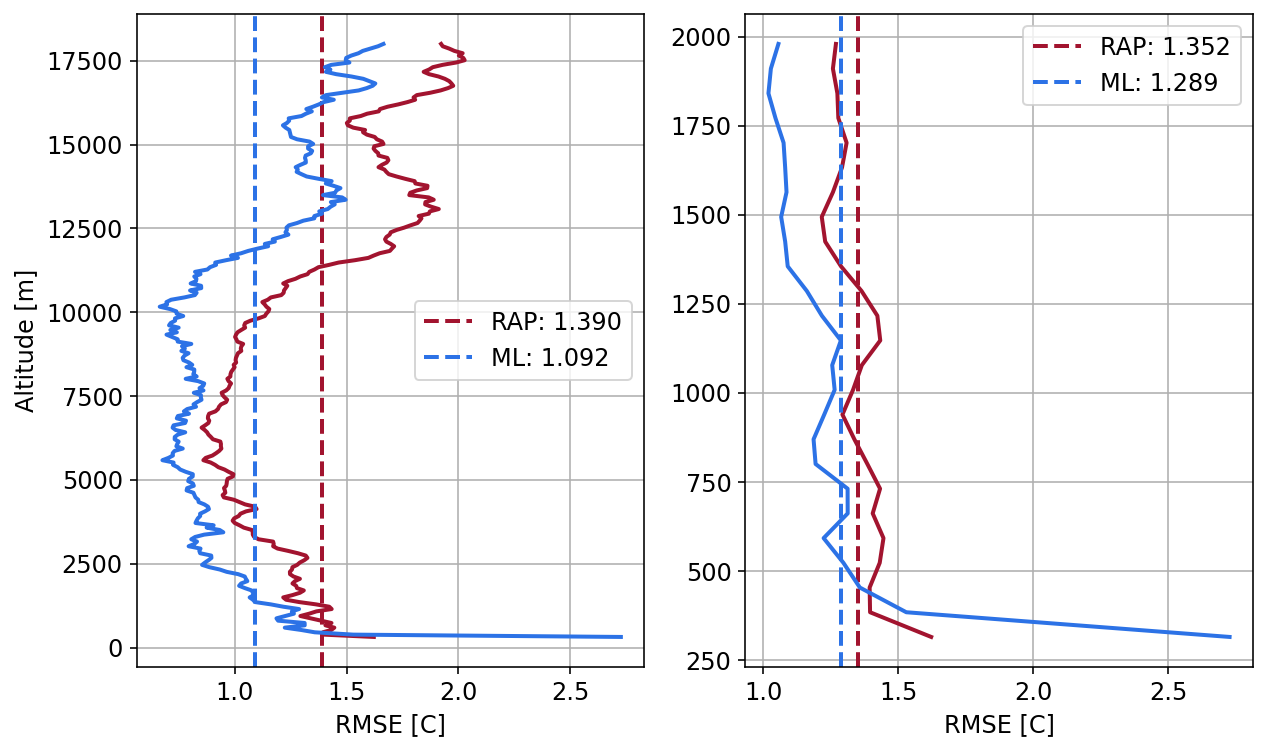

In [34]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

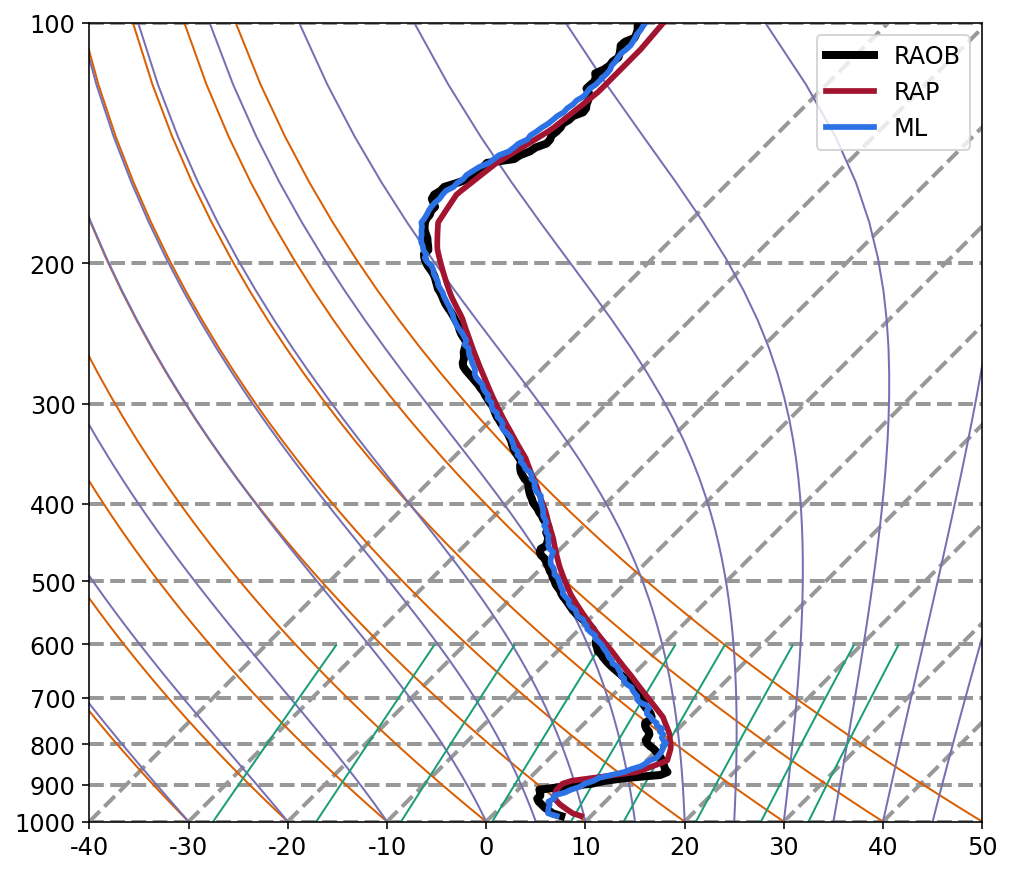

In [35]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

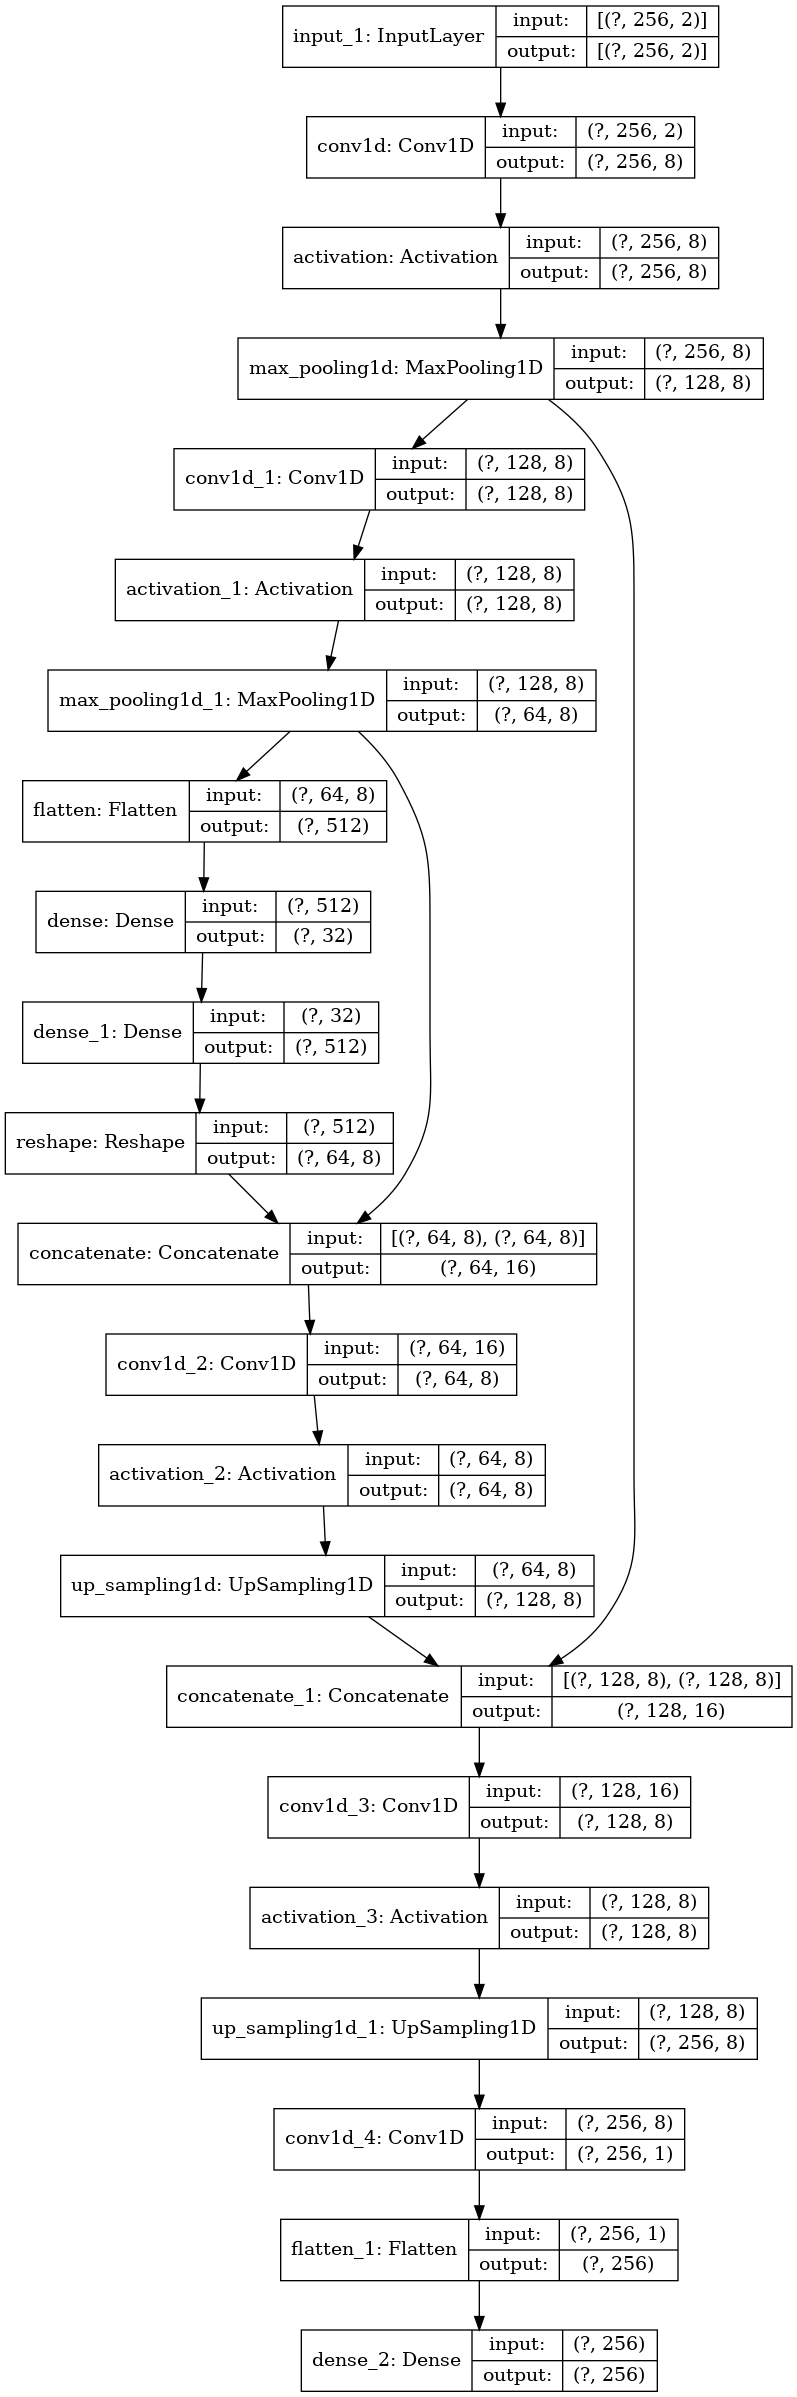

In [36]:
tf.keras.utils.plot_model(nnet.model, '/home/stock/research/media/unet.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

### Moisture

In [60]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

In [61]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [8, 8], [(10, 1)]*2,
                         Ttrain.shape[1], activation='tanh',
                         n_hidden_dims=32, seed=1234)
nnet.train(Xtrain, Ttrain, 35, 32, method='adam', verbose=False,
           learning_rate=0.001, validation=[Xtest, Ttest])

SkipNeuralNetwork((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.23159 in 9.6398 seconds.

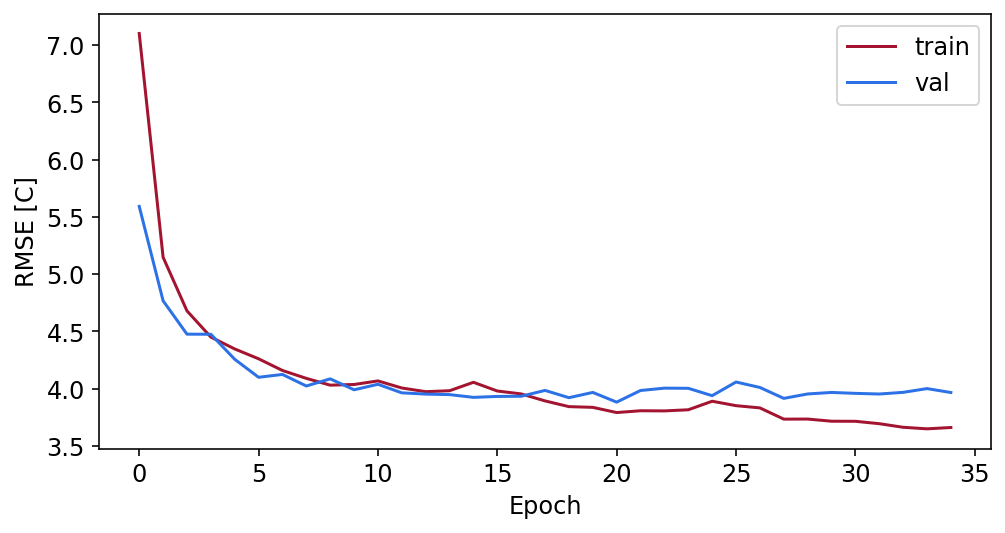

In [62]:
results.plot_loss(nnet)

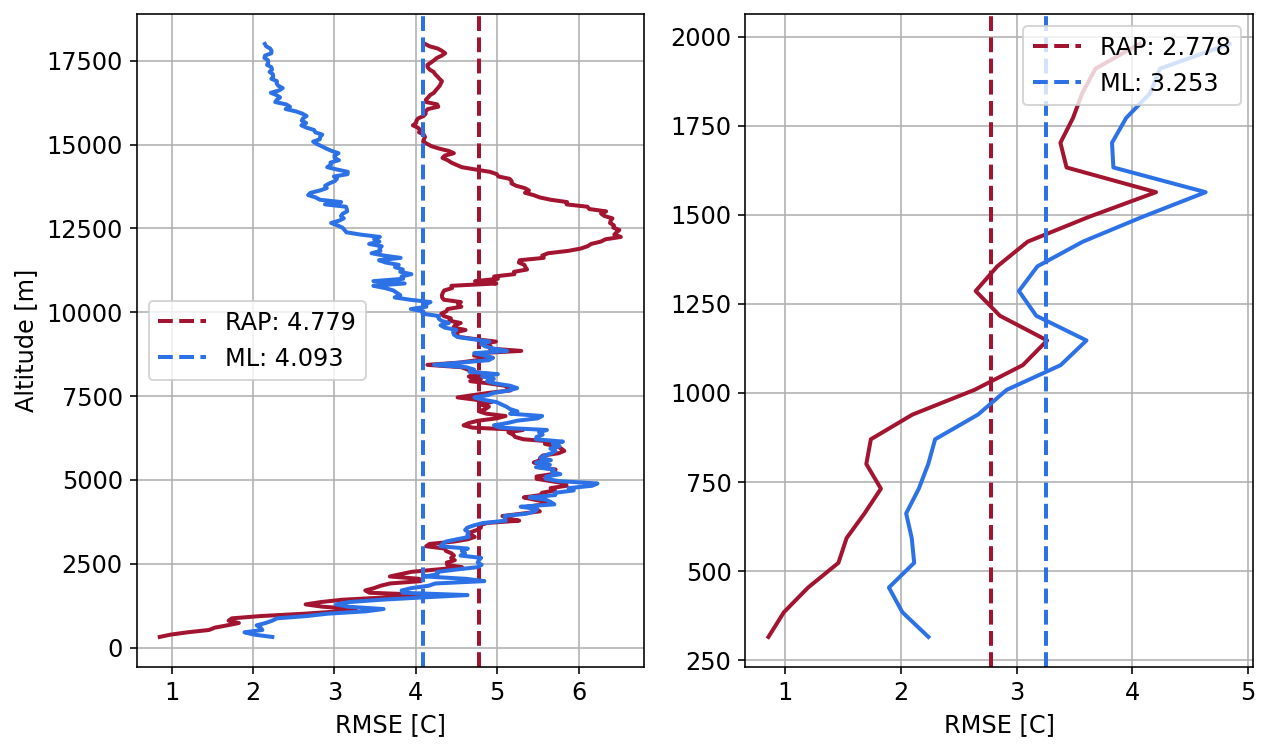

In [63]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

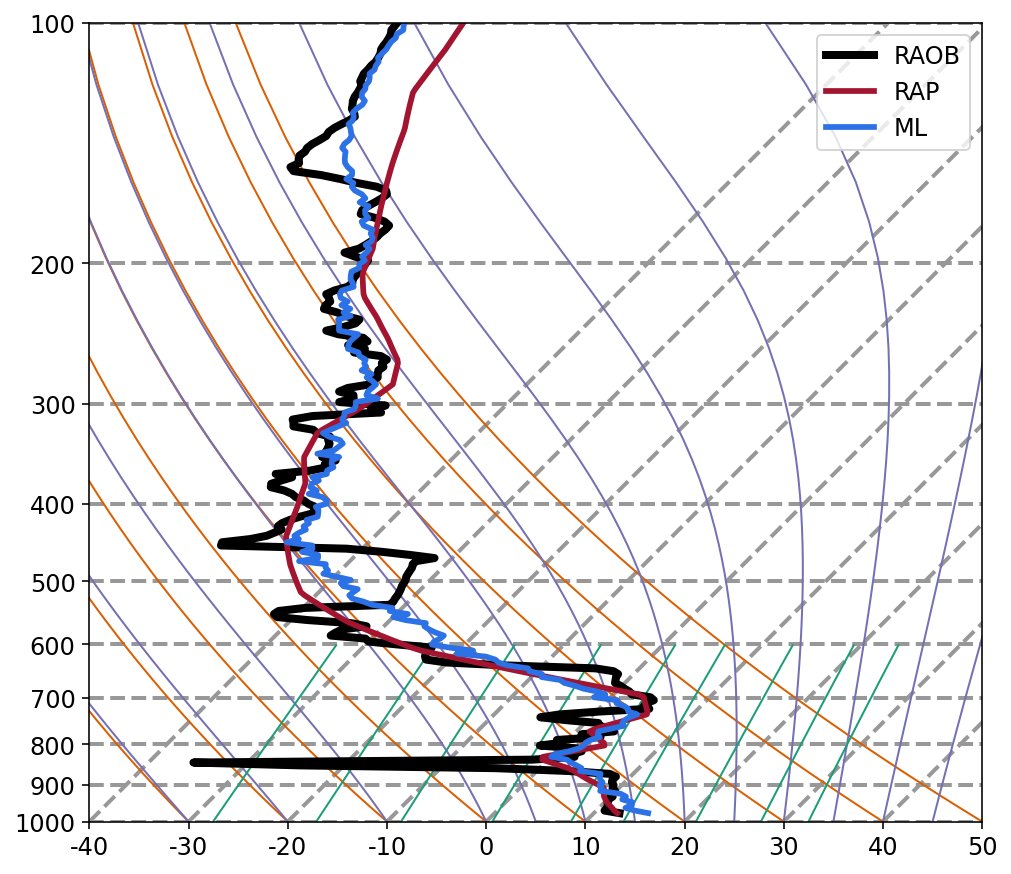

In [64]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Transfer Learning RAOB

Best performance is noticed when retraining over the entire model, or freezing the weights before the latent vector.

In [37]:
def insert_intermediate_layer(model, layer_regex, layer_factory):
    x = model.layers[0].output
    for layer in model.layers[1:]:
        x = layer(x)
        if re.match(layer_regex, layer.name):
            new_layer = layer_factory()
            new_layer._name = f'{layer.name}_{new_layer.name}'
            x = new_layer(x)
            print(f'Added {new_layer.name} after {layer.name}')
    return tf.keras.Model(model.layers[0].input, x)

In [39]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

In [59]:
## 0.970 with raob_cae freeze before `dense` with 20, 32, 0.0001 'adam'

nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_moisture_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_temperature_cnn')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_temperature_cae')

def dropout_layer_factory():
    return tf.keras.layers.Dropout(rate=0.2, name='dropout')
def batchnorm_layer_factory():
    return tf.keras.layers.BatchNormalization(name='batch_norm')

# (?<![\w\d])dense(?![\w\d])
# nnet.model = insert_intermediate_layer(nnet.model, '(?<![\w\d])conv1d(?![\w\d])', batchnorm_layer_factory)
# nnet.model = insert_intermediate_layer(nnet.model, 'max_pool', dropout_layer_factory)

# for layer in nnet.model.layers[:-2]:
#     if layer == nnet.model.get_layer('dense'):
#         break
#     layer.trainable = False
    
nnet.model.trainable = False
    
# Remove last Dense layer and add new one.
x = nnet.model.layers[-2].output
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256)(x)
nnet.model = tf.keras.Model(nnet.model.layers[0].input, x)
    
nnet.train(Xtrain, Ttrain, 20, 32, validation=[Xtest, Ttest], method='adam',
                 learning_rate=0.001, verbose=True)

epoch: 0, rmse 4.95107, val_rmse 3.85870
epoch: 5, rmse 2.17407, val_rmse 1.64850
epoch: 10, rmse 1.85505, val_rmse 1.29578
epoch: 15, rmse 1.72353, val_rmse 1.18399
epoch: 19, rmse 1.66528, val_rmse 1.14644
finished!


ConvolutionalAutoEncoder((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.08971 in 4.2490 seconds.

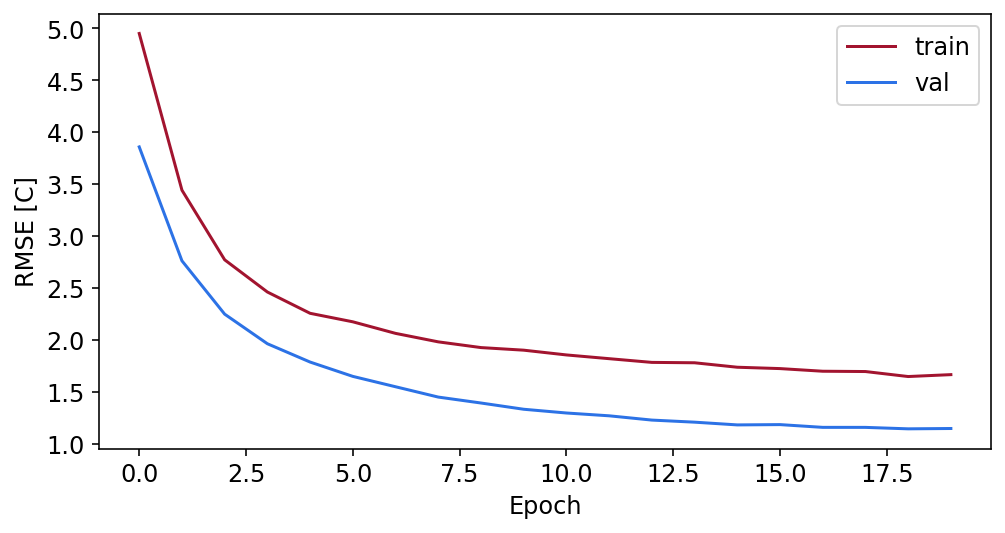

In [61]:
results.plot_loss(nnet)

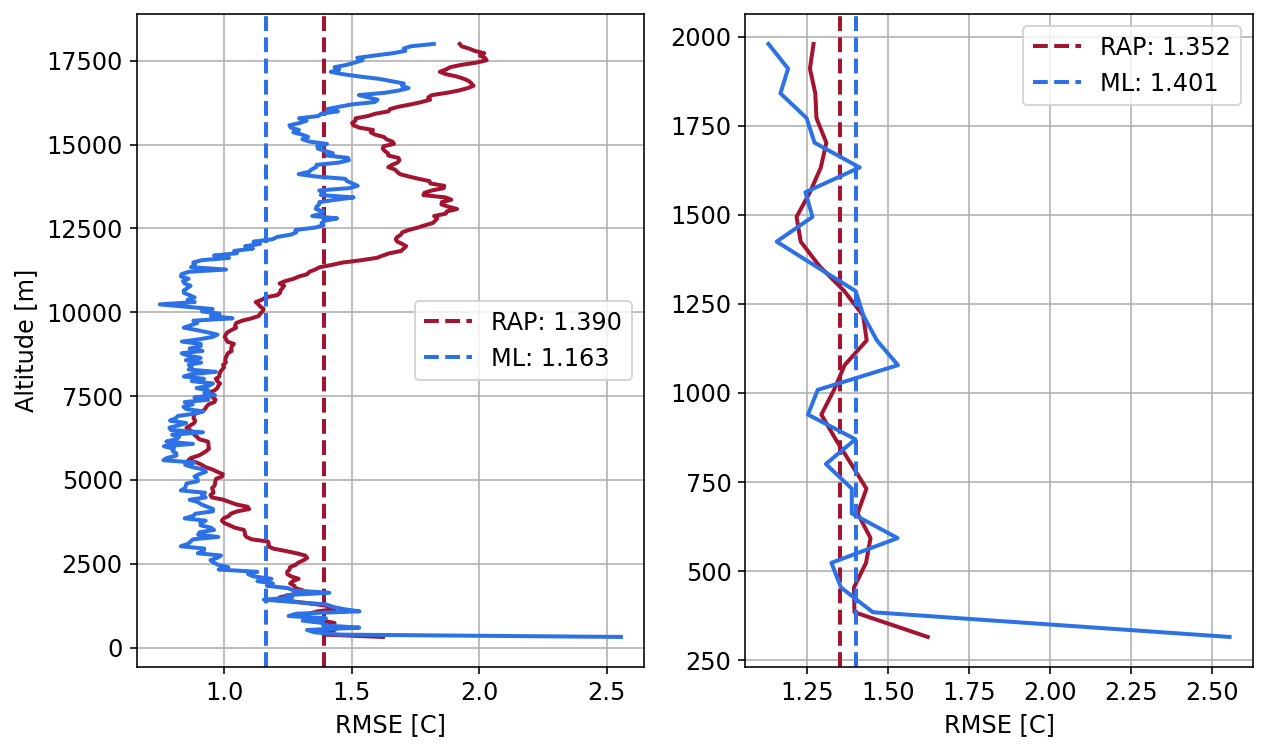

In [62]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                            # file_name=f"/home/stock/research/media/transferlearning-temp-profile.png")

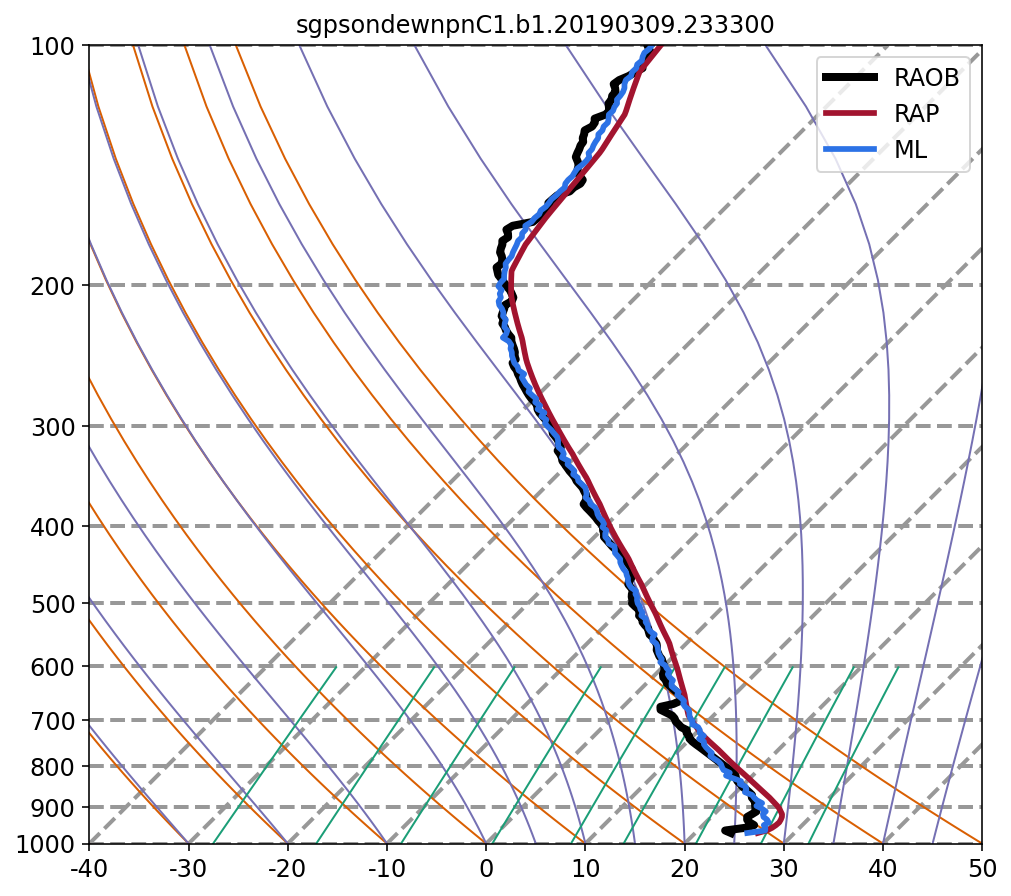

In [60]:
i = 69 # 69
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1])[0]

# sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = Ttest[i,:,1]
# sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = Xtest[i,:,dl.DEWPOINT]
# sounding[radiosonde_utils.PREDICTED_DEWPOINT_COLUMN_KEY] = moist_nnet.use(Xtest[i:i+1,:,[dl.PRESSURE,dl.DEWPOINT]])[0]

title = sonde_files[i].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");